<a href="https://colab.research.google.com/github/caiorodrigueess/Iniciacao-Cientifica/blob/main/PARTE_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to the modeling and simulation of Cellular Wireless Communication Systems - Part 2

Aluno: Caio Rodrigues dos Santos\
Universidade Federal do Ceará, Fortaleza, Brasil

## 1. Introdução

Essa é uma continuação da primeira parte do projeto desenvolvido para introduzir o discente ao estudo de gerência de recursos de rádio e qualidade de serviço dos usuários, tendo como base o material 'Introduction to the modeling and simulation of Cellular Wireless Communication Systems - Part 2' disponibilizado pelo professor orientador.


No primeiro momento, foram introduzidos novos Indicadores Chave de Desempenho (KPIs), como a soma da capacidade, eficiência do espectro e taxa de interrupção. Além disso, foi apresentado um novo modelo de canal que inclui o *shadowing effect* - ou efeito de sombreamento, que reflete as flutuações
aleatórias do sinal devido ao ambiente físico.

## 2. Objetivos

Aprofundar os estudos sobre Comunicações Móveis, além de analisar novos indicadores de desempenho e técnicas de Gerência de Recursos Rádio, incluindo alocação de canais, agregação e controle de potência, bem como estratégias de handover para usuários móveis. O propósito é avaliar a Qualidade do Serviço e
oferecer melhorias de desempenho sem custos adicionais de infraestrutura.

## 3. Resumo das Atividades e Conceitos Absorvidos

A configuração base do sistema continua a mesma para alguns aspectos, mas foram definidos números fixos de UEs e APs:


*   **Área de cobertura:** 1km²;
*   **QoS:** 100 Mbps no 10th percentil da capacidade do canal;
*   **Número de UEs:** K = 13;
*   **Número de APs:** M = 64.

### 3.1. Novos Indicadores de Desempenho

Foram introduzidos novos KPIs que permitem uma avaliação mais completa e eficiente do sistema:


*   **Capacidade de soma (Sum-Capacity):** Representa a taxa total do sistema, somando a capacidade de todos os UEs em ”uma rodada” de simulação.
*   **Eficiência espectral de área (Area Spectrum Efficiency - ASE):** Mede a eficiência da rede, normalizando a capacidade de soma média pela largura de banda total e pela área de cobertura (km²).
*   **Eficiência energética (Energy Efficiency):** Avaliação da energia necessária para transmitir um bit de dados, medida em bits/Joule. Pode ser relacionada com a duração da bateria de um UE.
*   **Taxa de interrupção (Outage rate):** Define a qualidade do serviço mínima que um sistema deve ter. Nesse programa, buscamos 25 Mbps no 5th percentil.

### 3.2. Modelo de canal com shadowing

Na primeira parte, consideramos a distância AP-UE como o fator definitivo para o path gain. Agora, adicionamos uma variável aleatória lognormal em cada enlace de rádio entre um UE e um AP. Dessa forma, as flutuações aleatórias do ambiente físico são adicionadas aos cálculos, tornando a simulação mais fiel à realidade.

## 4. Exercícios

Nesta seção, constam as resoluções dos exercícios propostos no material disponibilizado pelo professor orientador. A fim de manter a clareza das informações, os códigos utilizados foram ocultados da visualização, porém eles podem ser facilmente acessados.

### Exercício 1

In [ ]:
# @title
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)

class AP:
    def __init__(self, x: float, y: float, id: int):
        self.x = x
        self.y = y
        self.id = id
        self.channel = None
        self.ues = []

    def __str__(self):
        return f'AP[{self.id}]({self.x}, {self.y})'

class UE:
    def __init__(self, N: int):
        self.x = np.random.randint(0, 1001)
        self.y = np.random.randint(0, 1001)
        self.ap = None
        self.channel = np.random.randint(1, N+1)
        self.dist = 0

    def __str__(self):
        return f'UE({self.x}, {self.y})'

def distribuir_AP(M: int) -> np.ndarray:
    APs = []
    dx = 1000/(2*np.sqrt(M))
    a = np.arange(dx, 1001-dx, 2*dx)
    x, y = np.meshgrid(a, a)
    id = 1
    for xi, yi in zip(x.ravel(), y.ravel()):
        APs.append(AP(xi, yi, id))
        id += 1
    return APs

def dist_AP_UE(aps: list, ue: UE) -> float:
    dist = 1e4
    ap_mais_proximo = None

    # Encontra o AP mais próximo inicialmente
    for ap in aps:
        x = np.linalg.norm(np.array([ue.x, ue.y]) - np.array([ap.x, ap.y]))
        if x < dist:
            dist = x
            ap_mais_proximo = ap

    # Se a distância for menor que 1m, reposiciona a UE e recalcula para todos os APs
    while dist < 1:
        ue.x = np.random.randint(0, 1001)
        ue.y = np.random.randint(0, 1001)
        dist = 1e4
        ap_mais_proximo = None

        for ap in aps:
            x = np.linalg.norm(np.array([ue.x, ue.y]) - np.array([ap.x, ap.y]))
            if x < dist:
                dist = x
                ap_mais_proximo = ap

    # Atualiza as informações da UE e do AP correspondente
    ue.dist = dist
    ue.ap = ap_mais_proximo
    ap_mais_proximo.channel = ue.channel

    return dist

# Função para calcular o pr dos UEs interferentes
def pr_interferente(ue1: UE, ue2: UE) -> float:
    if ue1.channel == ue2.channel:
        dist = np.linalg.norm(np.array([ue1.ap.x, ue1.ap.y]) - np.array([ue2.x, ue2.y]))
        return 1*1e-4/(dist**4)
    return 0

def SINR(ue: UE, ues: list ,N: int) -> float:
    pt=1        # transmited power
    k=1e-4      # constant
    n=4         # path gain
    bt=1e8      # avaiable bandwidth
    k0=1e-20    # constant for the noise power

    pn = k0*bt/N
    pr = pt*k/(ue.dist**n)
    pr_int = np.sum([pr_interferente(ue, u) for u in ues if u!=ue])

    return pr/(pn + pr_int)

def channel_capacity(SINR: float, N: int) -> float:
    bt=100      # avaiable bandwidth
    return np.around((bt/N)*np.log2(1+SINR), 4)

def simular_experimento(M: int, sim: int) -> tuple:
    aps = distribuir_AP(M)  # Mantém a lista fixa de APs
    sinr = []
    cap_canal = []
    ues = []
    av_sum_cap = []
    for _ in range(sim):
        ues = [UE(2) for i in range(13)]
        sum_cap = 0
        for ue in ues:
            ue.dist = dist_AP_UE(aps, ue)
            s = SINR(ue, ues, 2)
            cap = channel_capacity(s, 2)
            sinr.append(s)
            cap_canal.append(cap)
            sum_cap += cap
        av_sum_cap.append(sum_cap)

    return sinr, cap_canal, np.mean(av_sum_cap)

def plot_cdfs(cdf: list, m: int, x: list, tipo: str = 'capacity') -> None:
    plt.figure(figsize=(10, 6))

    if tipo == 'sinr':
        # Ordena os valores da CDF
        for i in range(len(cdf)):
            # Atualizando todos os valores para log2(1 + x)
            cdf[i] = [np.log2(1 + a) for a in np.ravel(cdf[i])]

            cdf[i].sort()

            # Calcula os percentis de 0 a 1
            percentis = np.linspace(0, 1, len(cdf[i]))

            # Plota usando os percentis no eixo X
            plt.plot(cdf[i], percentis, label=f'{x[i]} canais')

        plt.yticks([0, 0.1, 0.3, 0.5, 0.7, 0.9, 1])
        plt.title(f'Estimativa do SINR pelo número de simulações ({m} APs)')
        plt.xlabel('SINR')

    else:
        for i in range(len(cdf)):
            # Ordena os valores da CDF
            cdf[i].sort()
            percentis = np.linspace(0, 1, len(cdf[i]))

            plt.plot(cdf[i], percentis, label=f'{x[i]} canais')

        plt.yticks([0, 0.1, 0.3, 0.5, 0.7, 0.9, 1])
        plt.axvline(x=100, color='r', linewidth=0.7, linestyle='--', label = '100 Mbps')
        plt.title(f'Estimativa da Capacidade do Canal pelo número de simulações ({m} APs)')
        plt.xlabel('Capacidade do Canal (Mbps)')

    plt.ylabel('Percentil')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
# @title
    M = [64, 49, 81]
    sim = 10000

    for m in M:
        sinr = []
        cap_canal = []
        x = []
        a, b, c = simular_experimento(m, sim)
        sinr.append(a)
        cap_canal.append(b)
        sum_cap = c
        ase = c/100
        print(f'Cenário: {m} APs e 2 canais')
        print(f'eficiência espectral de área: {ase:.2f} Mbps/Hz/km²')
        print(f'Capacidade de soma: {sum_cap:.2f} Mbps')
        print('--------')

Cenário: 64 APs e 2 canais
eficiência espectral de área: 33.27 Mbps/Hz/km²
Capacidade de soma: 3327.19 Mbps
--------
Cenário: 49 APs e 2 canais
eficiência espectral de área: 28.90 Mbps/Hz/km²
Capacidade de soma: 2889.53 Mbps
--------
Cenário: 81 APs e 2 canais
eficiência espectral de área: 37.41 Mbps/Hz/km²
Capacidade de soma: 3740.70 Mbps
--------


### Exercício 2

**UE 1 (na borda da célula)**
*   **Taxa de dados:** $\text{UE}_1 = 100 \, \text{Mbps}$
*   **Potência de transmissão:** $P_1 = 1 \, \text{J/s}$
\
\
$$
\eta_1 = \frac{100 \times 10^6}{1} = 10^8 \, \text{bits/Joule}
$$


**UE 2 (próximo ao AP)**
*   **Taxa de dados:** $\text{UE}_2 = 120 \, \text{Mbps}$
*   **Potência de transmissão:** $P_1 = 1 \, \text{J/s}$
\
\
$$
\eta_2 = \frac{120 \times 10^6}{0,1} = 1,2 \times 10^9 \, \text{bits/Joule}
$$


O UE 2 apresenta melhor eficiência energética, visto que transmite mais bits para cada Joule consumido.

### Exercício 3

In [ ]:
# @title
class AP:
    def __init__(self, x: float, y: float, id: int):
        self.x = x
        self.y = y
        self.id = id
        self.channel = None
        self.ues = []

    def __str__(self):
        return f'AP[{self.id}]({self.x}, {self.y})'

class UE:
    def __init__(self, N: int):
        self.x = np.random.randint(0, 1001)
        self.y = np.random.randint(0, 1001)
        self.ap = None
        self.channel = np.random.randint(1, N+1)
        self.dist = 0

    def __str__(self):
        return f'UE({self.x}, {self.y})'

def distribuir_AP(M: int) -> np.ndarray:
    APs = []
    dx = 1000/(2*np.sqrt(M))
    a = np.arange(dx, 1001-dx, 2*dx)
    x, y = np.meshgrid(a, a)
    id = 1
    for xi, yi in zip(x.ravel(), y.ravel()):
        APs.append(AP(xi, yi, id))
        id += 1
    return APs

def dist_AP_UE(M: int, ue: UE) -> float:
    aps = distribuir_AP(M)  # Mantém a lista fixa de APs
    dist = 1e4
    ap_mais_proximo = None

    # Encontra o AP mais próximo inicialmente
    for ap in aps:
        x = np.linalg.norm(np.array([ue.x, ue.y]) - np.array([ap.x, ap.y]))
        if x < dist:
            dist = x
            ap_mais_proximo = ap

    # Se a distância for menor que 1m, reposiciona a UE e recalcula para todos os APs
    while dist < 1:
        ue.x = np.random.randint(0, 1001)
        ue.y = np.random.randint(0, 1001)
        dist = 1e4
        ap_mais_proximo = None

        for ap in aps:
            x = np.linalg.norm(np.array([ue.x, ue.y]) - np.array([ap.x, ap.y]))
            if x < dist:
                dist = x
                ap_mais_proximo = ap

    # Atualiza as informações da UE e do AP correspondente
    ue.dist = dist
    ue.ap = ap_mais_proximo
    ap_mais_proximo.channel = ue.channel

    return dist

# Função para calcular o pr dos UEs interferentes
def pr_interferente(ue1: UE, ue2: UE) -> float:
    if ue1.channel == ue2.channel:
        dist = np.linalg.norm(np.array([ue1.ap.x, ue1.ap.y]) - np.array([ue2.x, ue2.y]))
        return 1*1e-4/(dist**4)
    return 0

def SINR(ue: UE, ues: list ,N: int) -> float:
    pt=1        # transmited power
    k=1e-4      # constant
    n=4         # path gain
    bt=1e8      # avaiable bandwidth
    k0=1e-20    # constant for the noise power

    pn = k0*bt/N
    pr = pt*k/(ue.dist**n)
    pr_int = np.sum([pr_interferente(ue, u) for u in ues if u!=ue])

    return pr/(pn + pr_int)

def channel_capacity(SINR: float, N: int) -> float:
    bt=100      # avaiable bandwidth
    return np.around((bt/N)*np.log2(1+SINR), 4)

def simular_experimento(N: int, sim: int) -> tuple:
    sinr = []
    cap_canal = []
    ues = []
    av_sum_cap = []
    for _ in range(sim):
        ues = [UE(N) for i in range(13)]
        for ue in ues:
            ue.dist = dist_AP_UE(64, ue)
            s = SINR(ue, ues, N)
            cap = channel_capacity(s, N)
            sinr.append(s)
            cap_canal.append(cap)

    return sinr, cap_canal, ues

if __name__ == '__main__':
    sim = 10000
    N = 1

    sinr, cap_canal, ues = simular_experimento(N, sim)
    print(f'5th percentil (Outage): {np.percentile(cap_canal, 5):.2f} Mbps')

5th percentil (Outage): 32.37 Mbps


### Exercício 4

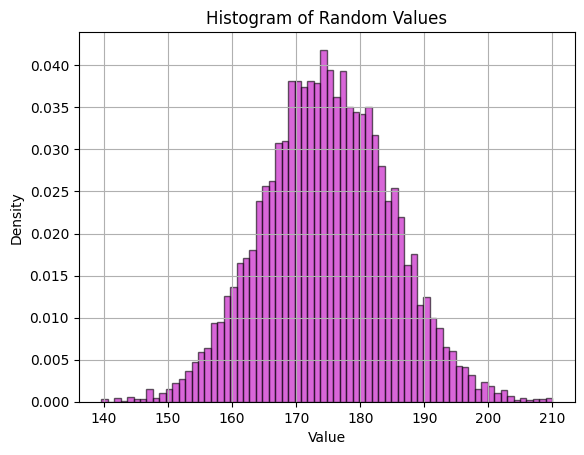

In [ ]:
# @title
# Parametros
mean = 175  # Média
std_dev = 10  # Desvio padrão

# Generate random values vector
vetor = np.random.normal(mean, std_dev, 10**4)

# Plot histogram
import matplotlib.pyplot as plt
plt.hist(vetor, bins=70, density=True, rwidth=1, alpha=0.6, color='m', edgecolor='black')
plt.title('Histogram of Random Values')
plt.xlabel('Value')
plt.ylabel('Density')
plt.grid(True)
plt.show()

### Exercício 5

Average sum capacity without shadowing effect: 3330.28 Mbps
10th percentile of SINR without shadowing effect: 3.32 dB
50th percentile of SINR without shadowing effect: 21.09 dB
10th percentile of channel capacity without shadowing effect: 105.62 Mbps
50th percentile of channel capacity without shadowing effect: 223.25 Mbps 

Average sum capacity with shadowing effect: 3274.12 Mbps
10th percentile of SINR with shadowing effect: 0.48 dB
50th percentile of SINR with shadowing effect: 20.55 dB
10th percentile of channel capacity with shadowing effect: 28.20 Mbps
50th percentile of channel capacity with shadowing effect: 221.48 Mbps 



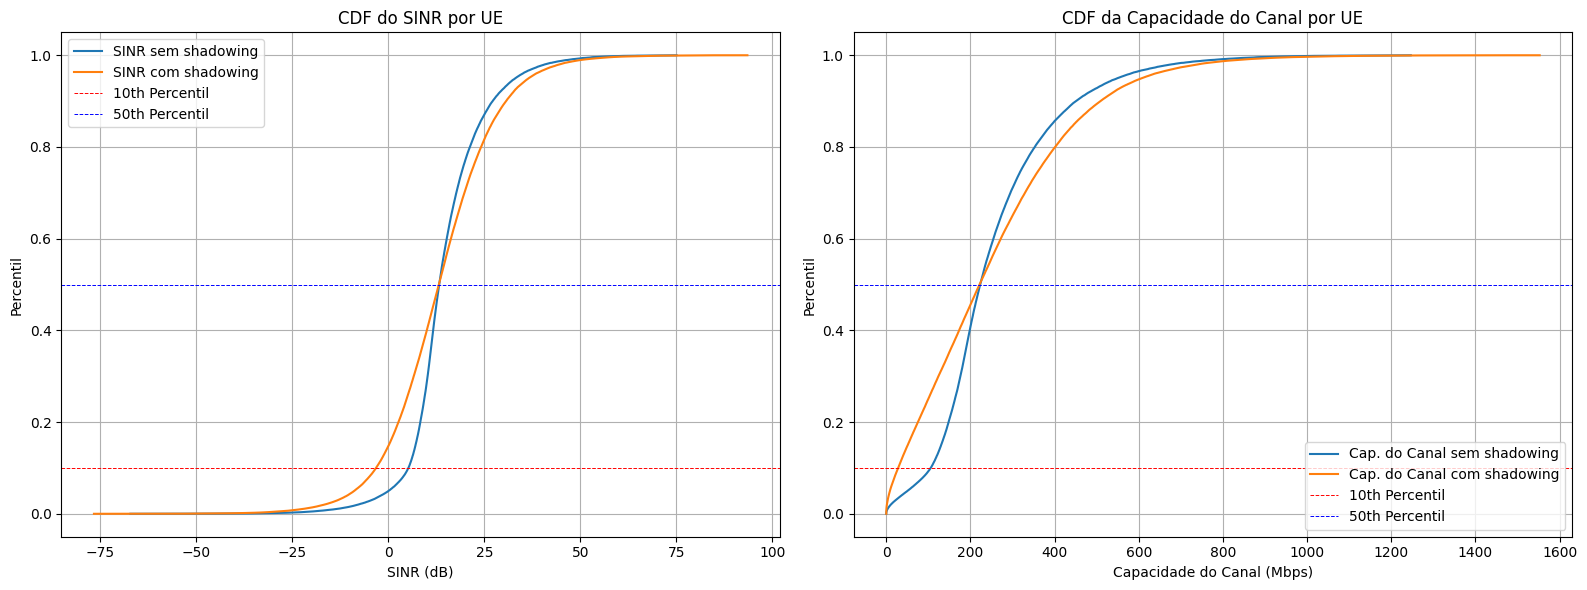

In [ ]:
# @title
import numpy as np
import matplotlib.pyplot as plt

class AP:
    def __init__(self, x: float, y: float, id: int):
        self.x = x
        self.y = y
        self.id = id
        self.channel = None
        self.ues = []

    def __str__(self):
        return f'AP[{self.id}]({self.x}, {self.y})'

class UE:
    def __init__(self, N: int):
        self.x = np.random.randint(0, 1001)
        self.y = np.random.randint(0, 1001)
        self.ap = None
        self.channel = np.random.randint(1, N+1)
        self.dist = 0

    def __str__(self):
        return f'UE({self.x}, {self.y})'

def distribuir_AP(M: int) -> list:
    APs = []
    dx = 1000/(2*np.sqrt(M))
    a = np.arange(dx, 1001-dx, 2*dx)
    x, y = np.meshgrid(a, a)
    id = 1
    for xi, yi in zip(x.ravel(), y.ravel()):
        APs.append(AP(xi, yi, id))
        id += 1
    return APs

def dist_AP_UE(aps: list, ue: UE):
    dist = 1e4
    ap_mais_proximo = None

    # Encontra o AP mais próximo inicialmente
    for ap in aps:
        x = np.linalg.norm(np.array([ue.x, ue.y]) - np.array([ap.x, ap.y]))
        if x < dist:
            dist = x
            ap_mais_proximo = ap

    # Se a distância for menor que 1m, reposiciona a UE e recalcula para todos os APs
    while dist < 1:
        ue.x = np.random.randint(0, 1001)
        ue.y = np.random.randint(0, 1001)
        dist = 1e4
        ap_mais_proximo = None

        for ap in aps:
            x = np.linalg.norm(np.array([ue.x, ue.y]) - np.array([ap.x, ap.y]))
            if x < dist:
                dist = x
                ap_mais_proximo = ap

    # Atualiza as informações da UE e do AP correspondente
    ue.dist = dist
    ue.ap = ap_mais_proximo
    ap_mais_proximo.channel = ue.channel

    return dist

def pr_interferente(ue1: UE, ue2: UE, shadowing:int = '') -> float:
    if ue1.channel == ue2.channel:
        dist = np.linalg.norm(np.array([ue1.ap.x, ue1.ap.y]) - np.array([ue2.x, ue2.y]))
        x = np.random.lognormal(0, 2) if shadowing == 'shadowing' else 1
        return x*1e-4/(dist**4)
    return 0

def SINR(ue: UE, ues: list ,N: int, shadowing: str='') -> float:
    pt=1        # transmited power
    k=1e-4      # constant
    n=4         # path gain
    bt=1e8      # avaiable bandwidth
    k0=1e-20    # constant for the noise power


    x = np.random.lognormal(0, 2) if shadowing == 'shadowing' else 1
    pn = k0*bt/N
    pr = x*pt*k/(ue.dist**n)
    pr_int = np.sum([pr_interferente(ue, u, shadowing) for u in ues if u!=ue])

    return pr/(pn + pr_int)

def channel_capacity(SINR: float, N: int) -> float:
    bt=100      # avaiable bandwidth
    return np.around((bt/N)*np.log2(1+SINR), 4)

def simular_experimento(M: int, N: int, sim: int, shadowing: str = '') -> tuple:
    aps = distribuir_AP(M)  # Mantém a lista fixa de APs
    sinr = []
    cap_canal = []
    ues = []
    av_sum_cap = []

    for _ in range(sim):
        ues = [UE(2) for i in range(13)]
        sum_cap = 0
        for ue in ues:
            ue.dist = dist_AP_UE(aps, ue)
            s = SINR(ue, ues, N, shadowing)
            cap = channel_capacity(s, N)

            sinr.append(s)
            cap_canal.append(cap)
            sum_cap += cap
        av_sum_cap.append(sum_cap)


    return sinr, cap_canal, np.mean(av_sum_cap)

def plot_cdfs(cdf_sinr: list, cdf_capacity: list) -> None:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Plot SINR CDF
    for i in range(len(cdf_sinr)):
        cdf_sinr[i] = [10*np.log10(a) for a in cdf_sinr[i]]
        cdf_sinr[i].sort()
        percentis = np.linspace(0, 1, len(cdf_sinr[i]))
        axes[0].plot(cdf_sinr[i], percentis, label=f'SINR {"com" if i==1 else "sem"} shadowing')

    axes[0].axhline(y=0.1, color='r', linewidth=0.7, linestyle='--', label = f'10th Percentil')
    axes[0].axhline(y=0.5, color='b', linewidth=0.7, linestyle='--', label = f'50th Percentil')
    axes[0].set_title('CDF do SINR por UE')
    axes[0].set_xlabel('SINR (dB)')
    axes[0].set_ylabel('Percentil')
    axes[0].legend()
    axes[0].grid(True)

    # Plot Capacity CDF
    for i in range(len(cdf_capacity)):
        cdf_capacity[i].sort()
        percentis = np.linspace(0, 1, len(cdf_capacity[i]))
        axes[1].plot(cdf_capacity[i], percentis, label=f'Cap. do Canal {"com" if i==1 else "sem"} shadowing')

    axes[1].axhline(y=0.1, color='r', linewidth=0.7, linestyle='--', label = f'10th Percentil')
    axes[1].axhline(y=0.5, color='b', linewidth=0.7, linestyle='--', label = f'50th Percentil')
    axes[1].set_title('CDF da Capacidade do Canal por UE')
    axes[1].set_xlabel('Capacidade do Canal (Mbps)')
    axes[1].set_ylabel('Percentil')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()


if __name__ == '__main__':
    M = 64
    N = 2
    sim = 10000

    sinr1, cap_canal1, av_sum_cap1 = simular_experimento(M, N, sim)
    print(f'Average sum capacity without shadowing effect: {av_sum_cap1:.2f} Mbps')
    print(f'10th percentile of SINR without shadowing effect: {np.percentile(sinr1, 10):.2f} dB')
    print(f'50th percentile of SINR without shadowing effect: {np.percentile(sinr1, 50):.2f} dB')
    print(f'10th percentile of channel capacity without shadowing effect: {np.percentile(cap_canal1, 10):.2f} Mbps')
    print(f'50th percentile of channel capacity without shadowing effect: {np.percentile(cap_canal1, 50):.2f} Mbps \n')

    sinr2, cap_canal2, av_sum_cap2 = simular_experimento(M, N, sim, 'shadowing')
    print(f'Average sum capacity with shadowing effect: {av_sum_cap2:.2f} Mbps')
    print(f'10th percentile of SINR with shadowing effect: {np.percentile(sinr2, 10):.2f} dB')
    print(f'50th percentile of SINR with shadowing effect: {np.percentile(sinr2, 50):.2f} dB')
    print(f'10th percentile of channel capacity with shadowing effect: {np.percentile(cap_canal2, 10):.2f} Mbps')
    print(f'50th percentile of channel capacity with shadowing effect: {np.percentile(cap_canal2, 50):.2f} Mbps \n')

    plot_cdfs([sinr1, sinr2], [cap_canal1, cap_canal2])

O valor do novo modelo de canal ser mais baixo é reflexo da maior flutuação do sistema, que considera os obstáculos físicos do ambiente. Podemos ver que, para valores abaixo da região próxima ao 50º percentil, o modelo de canal sem o efeito de shadowing possui maior SINR, que tem relação direta com a taxa de bits que o usuário recebe. Em especial, o 10º percentil chama a atenção quando comparamos com o modelo anterior devido ao valor consideravelmente mais baixo, tendo impacto significativo na Qualidade do Serviço. Para valores acima do 50º percentil, o modelo com shadowing tem uma leve vantagem em relação ao modelo usado anteriormente. Além disso, o modelo de canal com o efeito de shadowing apresenta uma curva mais linear, indicando maior dispersão dos dados - maior variabilidade entre os usuários.

### Exercício 6 (Channel Allocation)

#### Versão antiga

Average sum capacity with random channel allocation: 3671.78 Mbps
10th percentile of SINR with random channel allocation: 1.89 dB
50th percentile of SINR with random channel allocation: 34.65 dB
10th percentile of channel capacity with random channel allocation: 76.63 Mbps
50th percentile of channel capacity with random channel allocation: 257.79 Mbps 

Average sum capacity with per-AP channel allocation: 3827.82 Mbps
10th percentile of SINR with per-AP channel allocation: 2.99 dB
50th percentile of SINR with per-AP channel allocation: 39.60 dB
10th percentile of channel capacity with per-AP channel allocation: 99.90 Mbps
50th percentile of channel capacity with per-AP channel allocation: 267.16 Mbps 



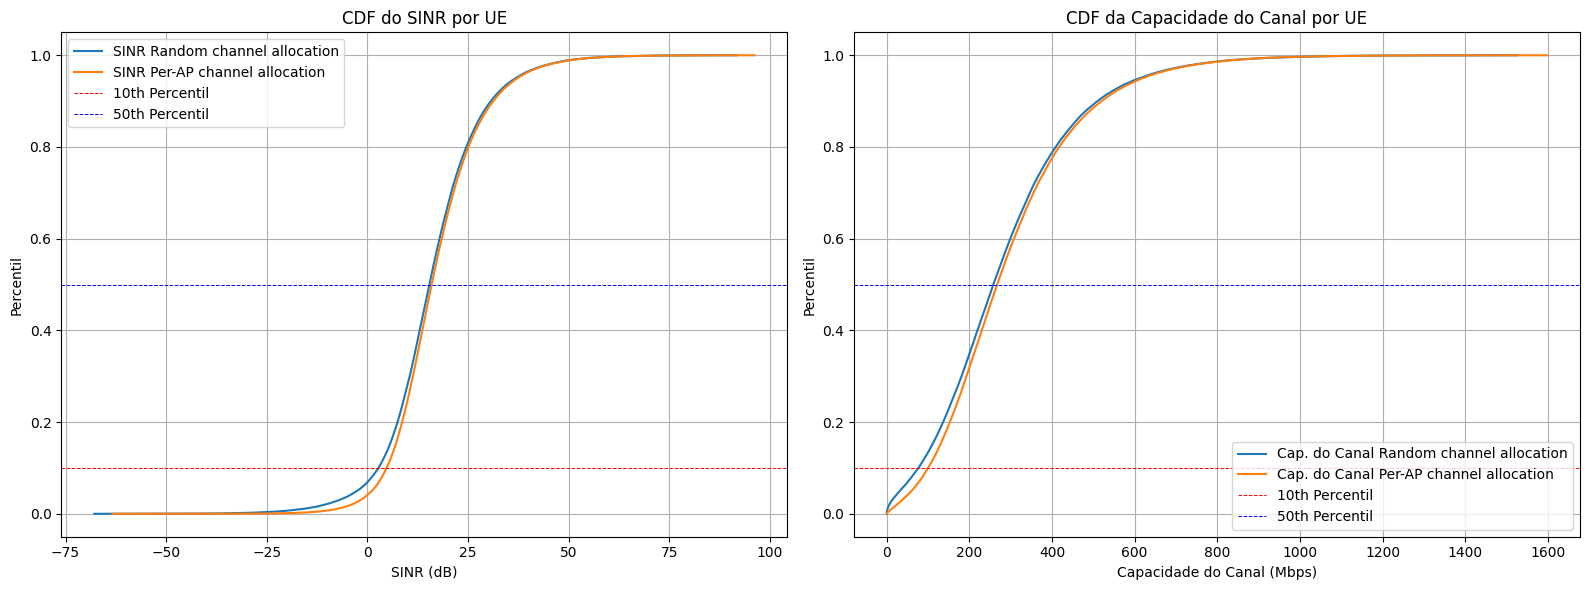

In [ ]:
# @title
from collections import Counter
np.random.seed(42)

class AP:
    def __init__(self, x: float, y: float, id: int):
        self.x = x
        self.y = y
        self.id = id
        self.channel = None
        self.ues = []

    def __str__(self):
        return f'AP[{self.id}]({self.x}, {self.y})'

class UE:
    id_counter = 0
    def __init__(self, N: int):
        self.id = UE.id_counter
        UE.id_counter += 1
        self.x = np.random.randint(0, 1001)
        self.y = np.random.randint(0, 1001)
        self.ap = None
        self.channel = 0
        self.dist = 0
        self.gain = 0

    def __str__(self):
        return f'UE({self.x}, {self.y})'

    def __eq__(self, other):
        if isinstance(other, UE):
            return self.id == other.id
        return False

def distribuir_AP(M: int) -> list:
    APs = []
    dx = 1000/(2*np.sqrt(M))
    a = np.arange(dx, 1001-dx, 2*dx)
    x, y = np.meshgrid(a, a)
    id = 1
    for xi, yi in zip(x.ravel(), y.ravel()):
        APs.append(AP(xi, yi, id))
        id += 1
    return APs

def attach_AP_UE(ue: UE, aps: list, posicoes_aps: np.ndarray, allocation:str) -> float:
    ap_coords = np.array([[ap.x, ap.y] for ap in aps])

    while True:
        ue_coord = np.array([ue.x, ue.y])
        distances = np.linalg.norm(ap_coords - ue_coord, axis=1)
        if np.all(distances >= 1):
            break
        ue.x = np.random.randint(0, 1001)
        ue.y = np.random.randint(0, 1001)

    # Cálculo vetorizado do ganho
    x = np.random.lognormal(0, 2, len(aps))
    distances = np.linalg.norm(ap_coords - np.array([ue.x, ue.y]), axis=1)
    distances = np.maximum(distances, 1)  # Evita divisão por 0
    gains = x * 1e-4 / (distances**4)
    best_index = np.argmax(gains)

    ue.ap = aps[best_index]
    ue.gain = gains[best_index]
    ue.dist = distances[best_index]
    aps[best_index].ues.append(ue)

     # Alocação de canal
    if allocation == 'random':
        ue.channel = np.random.randint(0, 2)

    elif allocation == 'per-AP':
        todos_os_canais = {0, 1}
        canais_em_uso = {u.channel for u in aps[best_index].ues[:-1]}
        canais_livres = list(todos_os_canais - canais_em_uso)
        if canais_livres:
            ue.channel = np.random.choice(canais_livres)
        else:
            canais = [u.channel for u in aps[best_index].ues[:-1]]
            canal_menos_usado = np.argmin(np.bincount(canais))
            ue.channel = canal_menos_usado

    return ue.dist

def SINR(ue: UE, ues: list ,N: int) -> float:
    pt=1        # transmited power
    bt=1e8      # avaiable bandwidth
    k0=1e-20    # constant for the noise power

    pn = k0*bt/N
    pr = ue.gain * pt

    interferentes = [u for u in ues if u != ue and u.channel == ue.channel]
    if not interferentes:
        return pr / pn

    interfer_coords = np.array([[u.x, u.y] for u in interferentes])
    ap_coord = np.array([ue.ap.x, ue.ap.y])
    distances = np.linalg.norm(interfer_coords - ap_coord, axis=1)
    distances = np.maximum(distances, 1)

    x = np.random.lognormal(0, 2, len(interferentes))
    pr_int = np.sum(x * 1e-4 / (distances ** 4))

    return pr / (pn + pr_int)

def channel_capacity(SINR: float, N: int) -> float:
    bt=100      # avaiable bandwidth
    return np.around((bt/N)*np.log2(1+SINR), 4)

def simular_experimento(M: int, N: int, sim: int, allocation: str = '') -> tuple:
    aps = distribuir_AP(M)  # Mantém a lista fixa de APs
    posicoes_aps = np.array([[ap.x, ap.y] for ap in aps])
    sinr = []
    cap_canal = []
    ues = []
    av_sum_cap = []

    for _ in range(sim):
        ues = [UE(N) for i in range(13)]
        sum_cap = 0
        for ue in ues:
            ue.dist = attach_AP_UE(ue, aps, posicoes_aps, allocation)

        for ue in ues:
            s = SINR(ue, ues, N)
            cap = channel_capacity(s, N)
            sum_cap += cap

            sinr.append(s)
            cap_canal.append(cap)
        av_sum_cap.append(sum_cap)

        for ap in aps:
            ap.ues = []  # Limpa a lista de UEs para o próximo experimento


    return sinr, cap_canal, np.mean(av_sum_cap)

def plot_cdfs(cdf_sinr: list, cdf_capacity: list) -> None:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Plot SINR CDF
    for i in range(len(cdf_sinr)):
        cdf_sinr[i] = [10*np.log10(a) for a in cdf_sinr[i]]
        cdf_sinr[i].sort()
        percentis = np.linspace(0, 1, len(cdf_sinr[i]))
        axes[0].plot(cdf_sinr[i], percentis, label=f'SINR {"Per-AP" if i==1 else "Random"} channel allocation')

    axes[0].axhline(y=0.10, color='r', linewidth=0.7, linestyle='--', label = f'10th Percentil')
    axes[0].axhline(y=0.50, color='b', linewidth=0.7, linestyle='--', label = f'50th Percentil')
    axes[0].set_title('CDF do SINR por UE')
    axes[0].set_xlabel('SINR (dB)')
    axes[0].set_ylabel('Percentil')
    axes[0].legend()
    axes[0].grid(True)

    # Plot Capacity CDF
    for i in range(len(cdf_capacity)):
        cdf_capacity[i].sort()
        percentis = np.linspace(0, 1, len(cdf_capacity[i]))
        axes[1].plot(cdf_capacity[i], percentis, label=f'Cap. do Canal {"Per-AP" if i==1 else "Random"} channel allocation')

    axes[1].axhline(y=0.10, color='r', linewidth=0.7, linestyle='--', label = f'10th Percentil')
    axes[1].axhline(y=0.50, color='b', linewidth=0.7, linestyle='--', label = f'50th Percentil')
    axes[1].set_title('CDF da Capacidade do Canal por UE')
    axes[1].set_xlabel('Capacidade do Canal (Mbps)')
    axes[1].set_ylabel('Percentil')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()


if __name__ == '__main__':
    M = 64
    N = 2
    sim = 10000

    sinr1, cap_canal1, av_sum_cap1 = simular_experimento(M, N, sim, 'random')
    print(f'Average sum capacity with random channel allocation: {av_sum_cap1:.2f} Mbps')
    print(f'10th percentile of SINR with random channel allocation: {np.percentile(sinr1, 10):.2f} dB')
    print(f'50th percentile of SINR with random channel allocation: {np.percentile(sinr1, 50):.2f} dB')
    print(f'10th percentile of channel capacity with random channel allocation: {np.percentile(cap_canal1, 10):.2f} Mbps')
    print(f'50th percentile of channel capacity with random channel allocation: {np.percentile(cap_canal1, 50):.2f} Mbps \n')

    sinr2, cap_canal2, av_sum_cap2 = simular_experimento(M, N, sim, 'per-AP')
    print(f'Average sum capacity with per-AP channel allocation: {av_sum_cap2:.2f} Mbps')
    print(f'10th percentile of SINR with per-AP channel allocation: {np.percentile(sinr2, 10):.2f} dB')
    print(f'50th percentile of SINR with per-AP channel allocation: {np.percentile(sinr2, 50):.2f} dB')
    print(f'10th percentile of channel capacity with per-AP channel allocation: {np.percentile(cap_canal2, 10):.2f} Mbps')
    print(f'50th percentile of channel capacity with per-AP channel allocation: {np.percentile(cap_canal2, 50):.2f} Mbps \n')

    plot_cdfs([sinr1, sinr2], [cap_canal1, cap_canal2])

#### Versão atualizada

Average sum capacity with random channel allocation: 3679.87 Mbps
10th percentile of SINR with random channel allocation: 1.89 dB
50th percentile of SINR with random channel allocation: 34.86 dB
10th percentile of channel capacity with random channel allocation: 76.59 Mbps
50th percentile of channel capacity with random channel allocation: 258.21 Mbps

Average sum capacity with per-AP channel allocation: 3859.65 Mbps
10th percentile of SINR with per-AP channel allocation: 3.44 dB
50th percentile of SINR with per-AP channel allocation: 40.64 dB
10th percentile of channel capacity with per-AP channel allocation: 107.57 Mbps
50th percentile of channel capacity with per-AP channel allocation: 268.99 Mbps



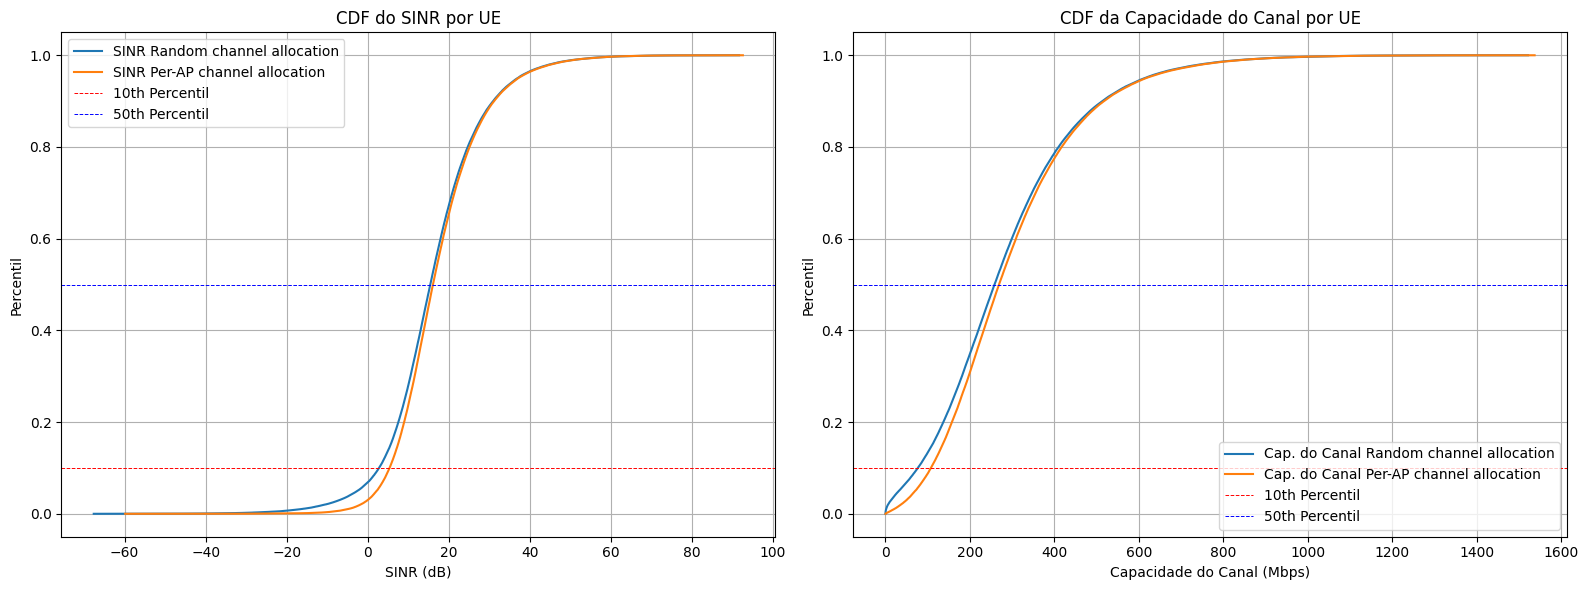

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

class AP:
    def __init__(self, x: float, y: float, id: int):
        self.x = x
        self.y = y
        self.id = id
        self.channel = None
        self.ues = []

    def __str__(self):
        return f'AP[{self.id}]({self.x}, {self.y})'

class UE:
    id_counter = 0
    def __init__(self, N: int):
        self.id = UE.id_counter
        UE.id_counter += 1
        self.x = np.random.randint(0, 1001)
        self.y = np.random.randint(0, 1001)
        self.ap = None
        self.channel = 0
        self.dist = 0
        self.gain = 0
        self.power = 1  # Transmit power

    def __str__(self):
        return f'UE({self.x}, {self.y})'

    def __eq__(self, other):
        if isinstance(other, UE):
            return self.id == other.id
        return False

def distribuir_AP(M: int) -> list:
    APs = []
    dx = 1000/(2*np.sqrt(M))
    a = np.arange(dx, 1001-dx, 2*dx)
    x, y = np.meshgrid(a, a)
    id = 0
    for xi, yi in zip(x.ravel(), y.ravel()):
        APs.append(AP(xi, yi, id))
        id += 1
    return APs

def gain_matrix(ues: list, aps: list) -> np.ndarray:
    ''' Inicializa a matriz'''
    G = np.zeros((len(ues), len(aps)))
    ap_coords = np.array([[ap.x, ap.y] for ap in aps])

    for i, ue in enumerate(ues):
        # garante que o UE não está a menos de 1 m de nenhum AP
        while True:
            ue_coord = np.array([ue.x, ue.y])
            d_all = np.linalg.norm(ap_coords - ue_coord, axis=1)
            if np.all(d_all >= 1):
                break
            ue.x = np.random.randint(0, 1001)
            ue.y = np.random.randint(0, 1001)

        # calcula ganhos para todos APs
        for j in range(len(aps)):
            d_ij = np.linalg.norm(ue_coord - ap_coords[j])
            d = max(d_ij, 1.0)
            G[i, j] = np.random.lognormal(0, 2) * 1e-4 / (d**4)
    return G

def alocar_canais_ortogonal(access_points, ues, number_channels, allocation):
    """
    Aloca canais aos UEs de forma ortogonal dentro de cada célula (AP).

    Esta função é uma adaptação do método 'channel_allocation'
    encontrado em wireless_system.py.

    Argumentos:
    access_points (list): A lista de objetos AccessPoint.
    user_equipaments (list): A lista de objetos UserEquipament.
    number_channels (int): O número total de canais ortogonais (N).

    Modifica:
    O atributo 'channel' de cada objeto na lista user_equipaments é
    atualizado "in-place" (no próprio objeto).
    """

    # 1. Zera os canais de todos os UEs
    # (Necessário para a lógica de "preenchimento" funcionar)
    for ue in ues:
        ue.channel = None

    if allocation == 'random':
        for ue in ues:
            ue.channel = np.random.randint(1, number_channels + 1)
        return None

    # 2. Inicializa o contador global de uso de canal
    # (Baseado em wireless_system.py)
    channels = {i: 0 for i in range(1, number_channels + 1)}

    # 3. Itera por cada AP para alocação intra-célula
    # (Baseado em wireless_system.py)
    for ap in access_points:
        available_channels = list(channels.keys())
        random.shuffle(available_channels)

        # 4. Itera pelos UEs (por índice) conectados a este AP
        # (Baseado em wireless_system.py)
        for ue0 in ap.ues:
            if not available_channels:
                # Para se o AP tiver mais UEs do que canais
                break

            # 5. Atribui um canal disponível e o remove da lista do AP
            channel = available_channels.pop()

            # 6. Atribui o canal ao UE e incrementa o contador global
            # (Baseado em wireless_system.py)
            index_ue = ue0.id
            ues[index_ue].channel = channel
            channels[channel] += 1

    # 7. Etapa de Preenchimento (Cleanup)
    # (Baseado em wireless_system.py)
    for ue in ues:
        if ue.channel is None:
            # Se o UE não recebeu um canal (passo 4),
            # atribui o canal menos usado globalmente.
            least_used_channel = min(channels, key=channels.get)
            ue.channel = least_used_channel
            channels[least_used_channel] += 1

def attach_AP_UE(ues: list, aps: list, G: np.ndarray) -> float:
    for i, ue in enumerate(ues):
        # Encontra o AP com o maior ganho para este UE
        best_index = np.argmax(G[i, :])
        ue.ap = aps[best_index]
        ue.gain = G[i, best_index]
        ue.dist = np.linalg.norm(np.array([ue.x, ue.y]) - np.array([ue.ap.x, ue.ap.y]))
        aps[best_index].ues.append(ue)


def SINR(ues: list, N: int, G: np.ndarray) -> float:
    pt=1        # transmited power
    bt=1e8      # avaiable bandwidth
    k0=1e-20    # constant for the noise power

    pn = k0*bt/N

    num_ues = len(ues)

    # Coleta os vetores de estado do sistema (extraídos dos objetos)
    # Vetor de Potência (P)
    P = np.array([ue.power for ue in ues])

    # Vetor de Associação de AP (A)
    # A[k] = índice do AP que serve o UE k
    A = np.array([ue.ap.id for ue in ues])

    # Vetor de Alocação de Canal (C)
    # C[k] = canal (ex: 1, 2, 3...) usado pelo UE k
    C = np.array([ue.channel for ue in ues])

    sinr_list = []

    # Itera por cada UE 'k' para calcular seu SINR
    for k in range(num_ues):

        # 1. Encontrar o AP de serviço para este UE 'k'
        m = A[k] # m é o índice do AP de serviço

        # 2. Calcular a Potência do Sinal (S)
        # (Sinal do UE k no AP m)
        # S = G[k, m] * P[k]
        S = G[k, m] * P[k]

        # 3. Calcular a Potência de Interferência (I)
        # (Soma da potência de todos os *outros* UEs 'i'
        #  que transmitem no mesmo canal 'C[k]'
        #  e são recebidos no *nosso* AP 'm')
        I = 0.0
        for i in range(num_ues):
            # A interferência ocorre se:
            # 1. Não é o próprio UE (i != k)
            # 2. O UE 'i' está no mesmo canal que o UE 'k' (C[i] == C[k])
            # (No seu código, a interferência inter-célula é considerada)
            if i != k and C[i] == C[k]:
                # I += G[i, m] * P[i]
                I += G[i, m] * P[i]

        # 5. Calcular SINR = S / (I + N)
        # (Lógica idêntica a WirelessSystem.calculate_SINR)
        sinr = S / (I + pn)
        sinr_list.append(sinr)

    return sinr_list

def channel_capacity(sinr_valores: list, N: int) -> list:
    # 1. Calcula a largura de banda por canal (B_canal)
    # (Baseado em wireless_system.py)
    B_per_channel = 1e8 / N

    # 2. Converte a(s) entrada(s) SINR para um array numpy
    #    para permitir o cálculo elemento a elemento (vetorizado).
    sinr_array = np.asarray(sinr_valores)

    # 3. Aplica a fórmula de Shannon-Hartley
    # (Baseado em wireless_system.py)
    # C = B * log2(1 + SINR)
    capacity_mbps = B_per_channel * np.log2(1 + sinr_array) / 1e6  # Converte para Mbps

    return capacity_mbps

def simular_experimento(M: int, N: int, sim: int, allocation: str = '') -> tuple:
    aps = distribuir_AP(M)  # Mantém a lista fixa de APs
    sinr = []
    cap_canal = []
    ues = []
    av_sum_cap = []

    for _ in range(sim):
        UE.id_counter = 0 # Reset UE counter for each simulation
        ues = [UE(N) for i in range(13)]
        sum_cap = 0
        G = gain_matrix(ues, aps)
        attach_AP_UE(ues, aps, G)
        alocar_canais_ortogonal(aps, ues, N, allocation)

        s = SINR(ues, N, G)
        cap = channel_capacity(s, N)
        sum_cap = np.sum(cap)

        sinr.extend(s)
        cap_canal.extend(cap)
        av_sum_cap.append(sum_cap)

        for ap in aps:
            ap.ues = []  # Limpa a lista de UEs para o próximo experimento

    return sinr, cap_canal, np.mean(av_sum_cap)

def plot_cdfs(cdf_sinr: list, cdf_capacity: list) -> None:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Plot SINR CDF
    for i in range(len(cdf_sinr)):
        cdf_sinr[i] = [10*np.log10(a) for a in cdf_sinr[i]]
        cdf_sinr[i].sort()
        percentis = np.linspace(0, 1, len(cdf_sinr[i]))
        axes[0].plot(cdf_sinr[i], percentis, label=f'SINR {"Per-AP" if i==1 else "Random"} channel allocation')

    axes[0].axhline(y=0.10, color='r', linewidth=0.7, linestyle='--', label = f'10th Percentil')
    axes[0].axhline(y=0.50, color='b', linewidth=0.7, linestyle='--', label = f'50th Percentil')
    axes[0].set_title('CDF do SINR por UE')
    axes[0].set_xlabel('SINR (dB)')
    axes[0].set_ylabel('Percentil')
    axes[0].legend()
    axes[0].grid(True)

    # Plot Capacity CDF
    for i in range(len(cdf_capacity)):
        cdf_capacity[i].sort()
        percentis = np.linspace(0, 1, len(cdf_capacity[i]))
        axes[1].plot(cdf_capacity[i], percentis, label=f'Cap. do Canal {"Per-AP" if i==1 else "Random"} channel allocation')

    axes[1].axhline(y=0.10, color='r', linewidth=0.7, linestyle='--', label = f'10th Percentil')
    axes[1].axhline(y=0.50, color='b', linewidth=0.7, linestyle='--', label = f'50th Percentil')
    axes[1].set_title('CDF da Capacidade do Canal por UE')
    axes[1].set_xlabel('Capacidade do Canal (Mbps)')
    axes[1].set_ylabel('Percentil')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    M = 64
    N = 2
    sim = 10000

    sinr1, cap_canal1, av_sum_cap1 = simular_experimento(M, N, sim, 'random')
    print(f'Average sum capacity with random channel allocation: {av_sum_cap1:.2f} Mbps')
    print(f'10th percentile of SINR with random channel allocation: {np.percentile(sinr1, 10):.2f} dB')
    print(f'50th percentile of SINR with random channel allocation: {np.percentile(sinr1, 50):.2f} dB')
    print(f'10th percentile of channel capacity with random channel allocation: {np.percentile(cap_canal1, 10):.2f} Mbps')
    print(f'50th percentile of channel capacity with random channel allocation: {np.percentile(cap_canal1, 50):.2f} Mbps\n')

    sinr2, cap_canal2, av_sum_cap2 = simular_experimento(M, N, sim, 'per-AP')
    print(f'Average sum capacity with per-AP channel allocation: {av_sum_cap2:.2f} Mbps')
    print(f'10th percentile of SINR with per-AP channel allocation: {np.percentile(sinr2, 10):.2f} dB')
    print(f'50th percentile of SINR with per-AP channel allocation: {np.percentile(sinr2, 50):.2f} dB')
    print(f'10th percentile of channel capacity with per-AP channel allocation: {np.percentile(cap_canal2, 10):.2f} Mbps')
    print(f'50th percentile of channel capacity with per-AP channel allocation: {np.percentile(cap_canal2, 50):.2f} Mbps\n')

    plot_cdfs([sinr1, sinr2], [cap_canal1, cap_canal2])

### Exercício 7 (Channel Aggregation)

#### **Versão antiga**

Esse código possui uma incoerência no cálculo do efeito de *shadowing*, onde os valores são calculados mais de uma vez.

--- Without channel aggregation ---
Average sum capacity: 3818.51 Mbps
10th percentile of SINR: 2.94 dB
50th percentile of SINR: 39.56 dB
10th percentile of channel capacity: 98.87 Mbps
50th percentile of channel capacity: 267.09 Mbps

--- With channel aggregation ---
Average sum capacity: 6025.90 Mbps
10th percentile of SINR: 1.62 dB
50th percentile of SINR: 21.23 dB
10th percentile of channel capacity: 142.92 Mbps
50th percentile of channel capacity: 393.09 Mbps


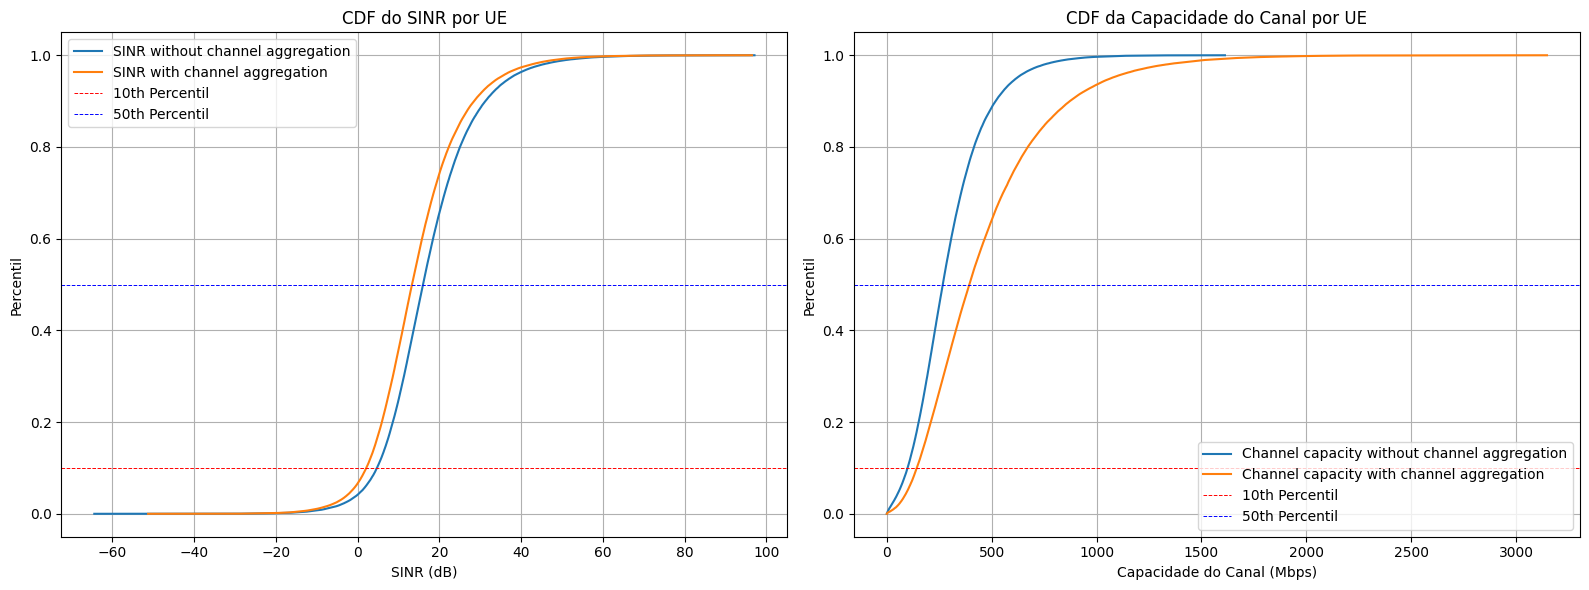

In [ ]:
# @title
import numpy as np
import matplotlib.pyplot as plt

class AP:
    def __init__(self, x: float, y: float, id: int):
        self.x = x
        self.y = y
        self.id = id
        self.channel = None
        self.ues = []

    def __str__(self):
        return f'AP[{self.id}]({self.x}, {self.y})'

class UE:
    id_counter = 0
    def __init__(self):
        self.id = UE.id_counter
        UE.id_counter += 1
        self.x = np.random.randint(0, 1001)
        self.y = np.random.randint(0, 1001)
        self.ap = None
        self.channel = 0
        self.dist = 0
        self.gain = 0
        self.ca = False
        self.sinr = 0

    def __str__(self):
        return f'UE({self.x}, {self.y})'

    def __eq__(self, other):
        if isinstance(other, UE):
            return self.id == other.id
        return False

def distribuir_AP(M: int) -> list:
    APs = []
    dx = 1000/(2*np.sqrt(M))
    a = np.arange(dx, 1001-dx, 2*dx)
    x, y = np.meshgrid(a, a)
    id = 1
    for xi, yi in zip(x.ravel(), y.ravel()):
        APs.append(AP(xi, yi, id))
        id += 1
    return APs

def attach_AP_UE(ue: UE, aps: list) -> float:
    ap_coords = np.array([[ap.x, ap.y] for ap in aps])

    while True:
        ue_coord = np.array([ue.x, ue.y])
        distances = np.linalg.norm(ap_coords - ue_coord, axis=1)
        if np.all(distances >= 1):
            break
        ue.x = np.random.randint(0, 1001)
        ue.y = np.random.randint(0, 1001)

    # Cálculo vetorizado do ganho
    x = np.random.lognormal(0, 2, len(aps))
    distances = np.linalg.norm(ap_coords - np.array([ue.x, ue.y]), axis=1)
    distances = np.maximum(distances, 1)  # Evita divisão por 0
    gains = x * 1e-4 / (distances**4)
    best_index = np.argmax(gains)

    ue.ap = aps[best_index]
    ue.gain = gains[best_index]
    ue.dist = distances[best_index]
    aps[best_index].ues.append(ue)

    todos_os_canais = {0, 1}
    canais_em_uso = {u.channel for u in aps[best_index].ues[:-1]}
    canais_livres = list(todos_os_canais - canais_em_uso)
    if canais_livres:
        ue.channel = np.random.choice(canais_livres)
    else:
        canais = [u.channel for u in aps[best_index].ues[:-1]]
        canal_menos_usado = np.argmin(np.bincount(canais))
        ue.channel = canal_menos_usado

    return ue.dist

def SINR(ue: UE, ues: list, N: int, ca: bool) -> float | list:
    pt=1        # transmited power
    bt=1e8      # avaiable bandwidth
    k0=1e-20    # constant for the noise power

    pn = k0*bt/N

    if ca and ue.ca:        # Se for o modelo com agregação de canal e a UE atual estiver usando CA, então calcula as duas SINRs
        pt = 0.5        # Divide a potencia
        pr = ue.gain * pt
        sinr = []       # Lista para armazenar as SINRs de cada canal

        for i in range(N):      # Para cada canal
            # Determina as UEs que estão usando o canal i (0 ou 1)
            interferentes = [u for u in ues if u != ue and i == u.channel]

            if not interferentes:       # Se não houver interferentes no canal
                sinr.append(pr / pn)    # Calcula apenas o SNR

            else:       # Se houver interferentes no canal
                # Calcula a interferencia na UE atual
                interfer_coords = np.array([[u.x, u.y] for u in interferentes])
                ap_coord = np.array([ue.ap.x, ue.ap.y])
                distances = np.linalg.norm(interfer_coords - ap_coord, axis=1)
                distances = np.maximum(distances, 1)

                x = np.random.lognormal(0, 2, len(interferentes))
                pr_int = np.sum(x * 1e-4 / (distances ** 4))

                sinr.append(pr / (pn + pr_int))
        ue.sinr = sinr
        return sinr

    pr = ue.gain * pt

    interferentes = [u for u in ues if u != ue and u.channel == ue.channel]
    if not interferentes:
        return pr / pn

    interfer_coords = np.array([[u.x, u.y] for u in interferentes])
    ap_coord = np.array([ue.ap.x, ue.ap.y])
    distances = np.linalg.norm(interfer_coords - ap_coord, axis=1)
    distances = np.maximum(distances, 1)

    x = np.random.lognormal(0, 2, len(interferentes))
    pr_int = np.sum(x * 1e-4 / (distances ** 4))

    sinr = pr / (pn + pr_int)

    ue.sinr = sinr
    return sinr

def channel_capacity(ue: UE, N: int, ca: bool) -> float:
    bt=100      # 100 MHz de largura de banda

    if ca and ue.ca:
        # Se for o modelo com agregação de canal, calcula a capacidade para cada canal e as soma
        return sum([np.around((bt/N)*np.log2(1+s), 4) for s in ue.sinr])

    # Se for o modelo sem agregação de canal, calcula a capacidade normalmente
    return np.around((bt/N)*np.log2(1+ue.sinr), 4)

def simular_experimento(M: int, N: int, sim: int, ca: bool = True) -> tuple:
    aps = distribuir_AP(M)  # Mantém a lista fixa de APs
    sinr = []
    cap_canal = []
    ues = []
    av_sum_cap = []

    for _ in range(sim):
        ues = [UE() for i in range(13)]
        sum_cap = 0
        for ue in ues:
            ue.dist = attach_AP_UE(ue, aps)

        if ca:
            for ue in ues:
                if len(ue.ap.ues) == 1:
                    ue.ca = True

        for ue in ues:
            s = SINR(ue, ues, N, ca)
            cap = channel_capacity(ue, N, ca)
            sum_cap += cap

            sinr.extend(x for x in s) if isinstance(s, list) else sinr.append(s)
            cap_canal.append(cap)
        av_sum_cap.append(sum_cap)

        for ap in aps:
            ap.ues = []  # Limpa a lista de UEs para o próximo experimento


    return sinr, cap_canal, np.mean(av_sum_cap)

def plot_cdfs(cdf_sinr: list, cdf_capacity: list) -> None:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Plot SINR CDF
    for i in range(len(cdf_sinr)):
        cdf_sinr[i] = [10*np.log10(a) for a in cdf_sinr[i]]
        cdf_sinr[i].sort()
        percentis = np.linspace(0, 1, len(cdf_sinr[i]))
        axes[0].plot(cdf_sinr[i], percentis, label=f'SINR {"with" if i==1 else "without"} channel aggregation')

    axes[0].axhline(y=0.10, color='r', linewidth=0.7, linestyle='--', label = f'10th Percentil')
    axes[0].axhline(y=0.50, color='b', linewidth=0.7, linestyle='--', label = f'50th Percentil')
    axes[0].set_title('CDF do SINR por UE')
    axes[0].set_xlabel('SINR (dB)')
    axes[0].set_ylabel('Percentil')
    axes[0].legend()
    axes[0].grid(True)

    # Plot Capacity CDF
    for i in range(len(cdf_capacity)):
        cdf_capacity[i].sort()
        percentis = np.linspace(0, 1, len(cdf_capacity[i]))
        axes[1].plot(cdf_capacity[i], percentis, label=f'Channel capacity {"with" if i==1 else "without"} channel aggregation')

    axes[1].axhline(y=0.10, color='r', linewidth=0.7, linestyle='--', label = f'10th Percentil')
    axes[1].axhline(y=0.50, color='b', linewidth=0.7, linestyle='--', label = f'50th Percentil')
    axes[1].set_title('CDF da Capacidade do Canal por UE')
    axes[1].set_xlabel('Capacidade do Canal (Mbps)')
    axes[1].set_ylabel('Percentil')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    M = 64
    N = 2
    sim = 10000


    sinr1, cap_canal1, av_sum_cap1 = simular_experimento(M, N, sim, False)
    print(f'--- Without channel aggregation ---')
    print(f'Average sum capacity: {av_sum_cap1:.2f} Mbps')
    print(f'10th percentile of SINR: {np.percentile(sinr1, 10):.2f} dB')
    print(f'50th percentile of SINR: {np.percentile(sinr1, 50):.2f} dB')
    print(f'10th percentile of channel capacity: {np.percentile(cap_canal1, 10):.2f} Mbps')
    print(f'50th percentile of channel capacity: {np.percentile(cap_canal1, 50):.2f} Mbps')

    sinr2, cap_canal2, av_sum_cap2 = simular_experimento(M, N, sim, True)
    print(f'\n--- With channel aggregation ---')
    print(f'Average sum capacity: {av_sum_cap2:.2f} Mbps')
    print(f'10th percentile of SINR: {np.percentile(sinr2, 10):.2f} dB')
    print(f'50th percentile of SINR: {np.percentile(sinr2, 50):.2f} dB')
    print(f'10th percentile of channel capacity: {np.percentile(cap_canal2, 10):.2f} Mbps')
    print(f'50th percentile of channel capacity: {np.percentile(cap_canal2, 50):.2f} Mbps')

    plot_cdfs([sinr1, sinr2], [cap_canal1, cap_canal2])

#### **Versão atualizada**

O ganho agora é calculado e armazenado em uma matriz, que guarda os valores de cada rodada simulação para ser usada no calculo do SINR de cada UE.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class AP:
    def __init__(self, x: float, y: float, id: int):
        self.x = x
        self.y = y
        self.id = id
        self.ues = [] # Lista de UEs conectados a este AP

    def __str__(self):
        return f'AP[{self.id}]({self.x}, {self.y})'

class UE:
    id_counter = 0
    def __init__(self):
        self.id = UE.id_counter
        UE.id_counter += 1
        self.x = np.random.randint(0, 1001)
        self.y = np.random.randint(0, 1001)
        self.ap = None
        self.gain = 0
        self.ca = False
        self.channels = []
        self.sinrs = []

    def __str__(self):
        return f'UE({self.x}, {self.y})'

    def __eq__(self, other):
        if isinstance(other, UE):
            return self.id == other.id
        return False

def distribuir_AP(M: int) -> list:
    APs = []
    dx = 1000/(2*np.sqrt(M))
    a = np.arange(dx, 1001-dx, 2*dx)
    x, y = np.meshgrid(a, a)
    id = 0    # id do AP
    for xi, yi in zip(x.ravel(), y.ravel()):
        APs.append(AP(xi, yi, id))
        id += 1
    return APs

def gain_matrix(ues: list, aps: list) -> np.ndarray:
    #matriz para armazenar o resultado
    G = np.zeros((len(ues), len(aps)))

    # garantindo que o UE esteja a mais de 1m do AP
    ap_coords = np.array([[ap.x, ap.y] for ap in aps])
    for i, ue in enumerate(ues):
        while True:
            ue_coord = np.array([ue.x, ue.y])
            d_all = np.linalg.norm(ap_coords - ue_coord, axis=1)
            if np.all(d_all >= 1):
                break
            ue.x = np.random.randint(0, 1001)
            ue.y = np.random.randint(0, 1001)

        distances = np.linalg.norm(ap_coords - ue_coord, axis=1)
        shadowing = np.random.lognormal(0, 2, size=len(aps))
        G[i, :] = shadowing * 1e-4 / (distances**4)           # itera sobre os UEs e calcula o ganho para cada AP
    return G

def channel_allocation(ue, aps, ues, N):
    # 1. Zera os canais de todos os UEs
    for ue in ues:
        ue.channels = []

    # 2. Inicializa o contador global
    channels = {i: 0 for i in range(1, N + 1)}
    # Lista de todas as chaves de canal
    all_channel_keys = list(channels.keys())

    # 3. Itera por cada AP
    for ap in aps:

        # --- LÓGICA DO CHANNEL AGGREGATION (Exercício 7) ---
        if allocation == 'CA' and len(ap.ues) == 1:
            ue_ca = ap.ues[0]
            # [cite_start]UE usa TODOS os canais disponíveis [cite: 352]
            ues[ue_ca.id].channel = all_channel_keys
            # Atualiza o contador global para ambos os canais
            for ch in all_channel_keys:
                channels[ch] += 1
        # --- FIM DA LÓGICA CA ---

        # [cite_start]Exercício 6: Caso contrário, aplica alocação ortogonal [cite: 354]
        else:
            available_channels = list(channels.keys())
            random.shuffle(available_channels)

            for ue0 in ap.ues:
                if not available_channels:
                    # Para se o AP tiver mais UEs do que canais
                    break

                channel = available_channels.pop()

                # Atribui uma lista com um canal
                ues[ue0.id].channel = [channel]
                channels[channel] += 1

    # 7. Etapa de Preenchimento (Cleanup)
    for ue in ues:
        # Checa se a lista de canais está vazia
        if not ue.channel:
            # Se o UE não recebeu um canal (nem CA, nem Ortogonal)
            least_used_channel = min(channels, key=channels.get)
            # Atribui uma lista com um canal
            ue.channel = [least_used_channel]
            channels[least_used_channel] += 1



def attach_AP_UE(ues: list, aps: list, G: np.ndarray) -> None:
    for i, ue in enumerate(ues):
        best_index = np.argmax(G[i, :])
        ue.ap = aps[best_index]
        ue.gain = G[i, best_index]
        ue.dist = np.linalg.norm(np.array([ue.x, ue.y]) - np.array([ue.ap.x, ue.ap.y]))
        aps[best_index].ues.append(ue)

def calcular_sinr(ues: list, aps: list, G: np.ndarray, p_vec: np.ndarray, pn: float):
    for i, ue in enumerate(ues):
        ue.sinrs = []
        if not ue.channels or ue.ap is None:
            continue

        ap_index = ue.ap.id
        potencia_por_canal_i = p_vec[i] / len(ue.channels)

        for canal_c in ue.channels:
            sinal = G[i, ap_index] * potencia_por_canal_i
            interf = 0.0
            for k, outro_ue in enumerate(ues):
                if i == k:
                    continue
                if canal_c in outro_ue.channels:
                    potencia_por_canal_k = p_vec[k] / len(outro_ue.channels)
                    interf += G[k, ap_index] * potencia_por_canal_k

            sinr_c = sinal / (pn + interf)
            ue.sinrs.append(sinr_c)

def channel_capacity(ue: UE, N: int, ca: bool) -> float:
    bt=100      # 100 MHz de largura de banda
    return np.around(sum([(bt/N)*np.log2(1+s) for s in ue.sinrs]), 4)

def simular_experimento(M: int, N: int, sim: int, ca: bool) -> tuple:
    aps = distribuir_AP(M)
    sinr_list_flat = []
    cap_canal_list = []
    av_sum_cap_list = []

    # Parâmetros da Simulação
    bt = 1e8
    k0 = 1e-20
    pn = k0 * bt / N

    for _ in range(sim):
        UE.id_counter = 0 # Reseta o contador de ID para cada simulação
        ues = [UE() for _ in range(13)]

        G = gain_matrix(ues, aps)
        attach_ues_to_aps(ues, aps, G, ca, N)

        pt = np.full(len(ues), 1.0)

        calcular_sinr(ues, aps, G, pt, pn)
        caps = [channel_capacity(ue, N, bt) for ue in ues]

        for ue in ues:
            sinr_list_flat.extend(ue.sinrs)
        cap_canal_list.extend(caps)
        av_sum_cap_list.append(np.sum(caps))

        for ap in aps:
            ap.ues = []
    print(ue.sinrs)

    return sinr_list_flat, cap_canal_list, np.mean(av_sum_cap_list)

def plot_cdfs(cdf_sinr: list, cdf_capacity: list) -> None:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Plot SINR CDF
    for i in range(len(cdf_sinr)):
        cdf_sinr[i] = [10*np.log10(a) for a in cdf_sinr[i]]
        cdf_sinr[i].sort()
        percentis = np.linspace(0, 1, len(cdf_sinr[i]))
        axes[0].plot(cdf_sinr[i], percentis, label=f'SINR {"with" if i==1 else "without"} channel aggregation')

    axes[0].axhline(y=0.10, color='r', linewidth=0.7, linestyle='--', label = f'10th Percentil')
    axes[0].axhline(y=0.50, color='b', linewidth=0.7, linestyle='--', label = f'50th Percentil')
    axes[0].set_title('CDF do SINR por UE')
    axes[0].set_xlabel('SINR (dB)')
    axes[0].set_ylabel('Percentil')
    axes[0].legend()
    axes[0].grid(True)

    # Plot Capacity CDF
    for i in range(len(cdf_capacity)):
        cdf_capacity[i].sort()
        percentis = np.linspace(0, 1, len(cdf_capacity[i]))
        axes[1].plot(cdf_capacity[i], percentis, label=f'Channel capacity {"with" if i==1 else "without"} channel aggregation')

    axes[1].axhline(y=0.10, color='r', linewidth=0.7, linestyle='--', label = f'10th Percentil')
    axes[1].axhline(y=0.50, color='b', linewidth=0.7, linestyle='--', label = f'50th Percentil')
    axes[1].set_title('CDF da Capacidade do Canal por UE')
    axes[1].set_xlabel('Capacidade do Canal (Mbps)')
    axes[1].set_ylabel('Percentil')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    M = 64
    N = 2
    sim = 10000

    sinr1, cap_canal1, av_sum_cap1 = simular_experimento(M, N, sim, False)
    print(f'--- Without channel aggregation ---')
    print(f'Average sum capacity: {av_sum_cap1:.2f} Mbps')
    print(f'10th percentile of SINR: {np.percentile(sinr1, 10):.2f} dB')
    print(f'50th percentile of SINR: {np.percentile(sinr1, 50):.2f} dB')
    print(f'10th percentile of channel capacity: {np.percentile(cap_canal1, 10):.2f} Mbps')
    print(f'50th percentile of channel capacity: {np.percentile(cap_canal1, 50):.2f} Mbps')

    sinr2, cap_canal2, av_sum_cap2 = simular_experimento(M, N, sim, True)
    print(f'\n--- With channel aggregation ---')
    print(f'Average sum capacity: {av_sum_cap2:.2f} Mbps')
    print(f'10th percentile of SINR: {np.percentile(sinr2, 10):.2f} dB')
    print(f'50th percentile of SINR: {np.percentile(sinr2, 50):.2f} dB')
    print(f'10th percentile of channel capacity: {np.percentile(cap_canal2, 10):.2f} Mbps')
    print(f'50th percentile of channel capacity: {np.percentile(cap_canal2, 50):.2f} Mbps\n')

    plot_cdfs([sinr1, sinr2], [cap_canal1, cap_canal2])

NameError: name 'attach_ues_to_aps' is not defined

### Exercício 8 (Power Control)

Average sum capacity without power control: 4460.21 Mbps
10th percentile of sinr without power control: -9.41 dB
50th percentile of sinr without power control: 5.17 dB
10th percentile of channel capacity without power control: 15.65 Mbps
50th percentile of channel capacity without power control: 210.12 Mbps

Average sum capacity with power control: 1137.74 Mbps
10th percentile of sinr with power control: -4.27 dB
50th percentile of sinr with power control: -1.09 dB
10th percentile of channel capacity with power control: 45.89 Mbps
50th percentile of channel capacity with power control: 82.98 Mbps



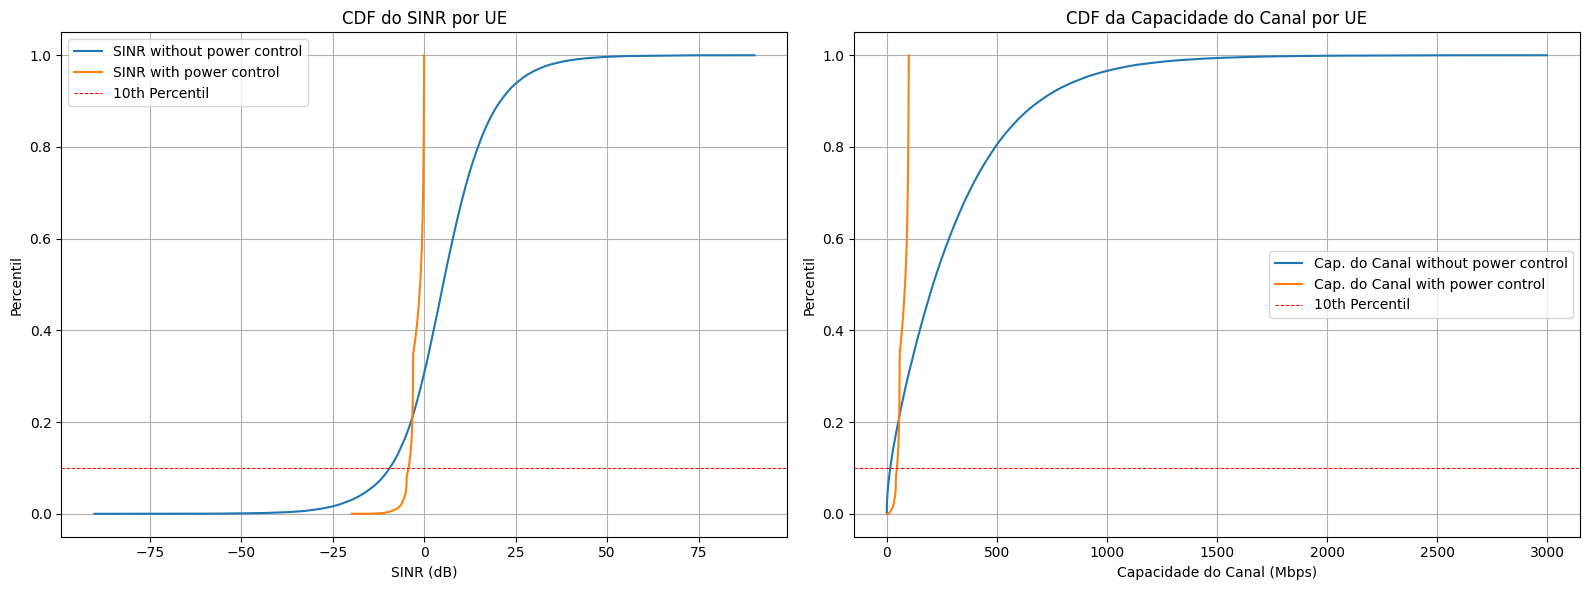

In [ ]:
# @title
import numpy as np
import matplotlib.pyplot as plt

class AP:
    def __init__(self, x: float, y: float, id: int):
        self.x = x
        self.y = y
        self.id = id
        self.channel = None
        self.ues = []

    def __str__(self):
        return f'AP[{self.id}]({self.x}, {self.y})'

class UE:
    id_counter = 0
    def __init__(self):
        self.id = UE.id_counter
        UE.id_counter += 1
        self.x = np.random.randint(0, 1001)
        self.y = np.random.randint(0, 1001)
        self.ap = None
        self.channel = 0
        self.dist = 0
        self.gain = 0
        self.ca = False
        self.sinr = 0
        self.pt = 1

    def __str__(self):
        return f'UE({self.x}, {self.y})'

    def __eq__(self, other):
        if isinstance(other, UE):
            return self.id == other.id
        return False

def distribuir_AP(M: int) -> list:
    APs = []
    dx = 1000/(2*np.sqrt(M))
    a = np.arange(dx, 1001-dx, 2*dx)
    x, y = np.meshgrid(a, a)
    id = 0
    for xi, yi in zip(x.ravel(), y.ravel()):
        APs.append(AP(xi, yi, id))
        id += 1
    return APs

def gain_matrix(ues: list, aps: list) -> np.ndarray:
    ''' Inicializa a matriz'''
    G = np.zeros((len(ues), len(aps)))
    ap_coords = np.array([[ap.x, ap.y] for ap in aps])

    for i, ue in enumerate(ues):
        # garante que o UE não está a menos de 1 m de nenhum AP
        while True:
            ue_coord = np.array([ue.x, ue.y])
            d_all = np.linalg.norm(ap_coords - ue_coord, axis=1)
            if np.all(d_all >= 1):
                break
            ue.x = np.random.randint(0, 1001)
            ue.y = np.random.randint(0, 1001)

        # calcula ganhos para todos APs
        for j, ap in enumerate(aps):
            d_ij = np.linalg.norm(ue_coord - ap_coords[j])
            d = max(d_ij, 1.0)
            G[i, j] = np.random.lognormal(0, 2) * 1e-4 / (d**4)

    return G

def attach_ues_to_aps(ues: list, aps: list, G: np.ndarray) -> None:
    for i, ue in enumerate(ues):
        best_index = np.argmax(G[i, :])   # AP com maior ganho
        ue.ap = aps[best_index]
        ue.gain = G[i, best_index]       # ganho fixo do link desejado
        aps[best_index].ues.append(ue)

    return None

def SINR(ues: list, aps: list, G: np.ndarray, p_vec: np.ndarray, pn: float) -> np.ndarray:
    sinr = np.zeros(len(ues))        # Inicializa o vetor de SINRs

    # Calcula o SINR para cada UE
    for i, ue in enumerate(ues):      # Itera sobre todos os UEs
        ap_index = ue.ap.id           # Busca o indice de qual AP o UE está conectado
        pr = G[i, ap_index] * p_vec[i]    # Calcula a potencia recebida por meio da matriz de ganhos e o vetor de potências

        # Caclcula a soma do pr de todos os UEs interferentes
        interf = np.sum([G[j, ap_index] * p_vec[j] for j in range(len(ues)) if j != i])

        # Armazena os valores de SINR
        sinr[i] = pr / (pn + interf)
        ue.sinr = sinr[i]

    return sinr

def channel_capacity(ue: UE, N: int) -> float:
    bt=100      # 100 MHz de largura de banda
    return np.around((bt/N)*np.log2(1+ue.sinr), 4)

def simular_experimento(M: int, N: int, sim: int, pc: bool = True) -> tuple:
    aps = distribuir_AP(M)  # Mantém a lista fixa de APs
    sinr = []
    cap_canal = []
    ues = []
    av_sum_cap = []

    # Parâmetros
    bt = 1e8
    k0 = 1e-20
    pn = k0 * bt / N
    pt_max = 1.0

    for _ in range(sim):
        ues = [UE() for i in range(15)] # Create UEs as a list

        G = gain_matrix(ues, aps)     # Calcula a matriz de ganhos
        attach_ues_to_aps(ues, aps, G)

        # Potências
        if pc:
            # Channel inversion (SNR alvo = 1)
            pt = np.array([min(pn/ue.gain, pt_max) for ue in ues])
        else:
            pt = np.full(len(ues), pt_max)

        # SINR e capacidades
        s = SINR(ues, aps, G, pt, pn)
        caps = [channel_capacity(ue, N) for ue in ues]

        sinr.extend(x for x in s)
        cap_canal.extend(caps)
        av_sum_cap.append(np.sum(caps))

        for ap in aps:
            ap.ues = []  # Limpa a lista de UEs para o próximo experimento

    return sinr, cap_canal, np.mean(av_sum_cap)

def plot_cdfs(cdf_sinr: list, cdf_capacity: list) -> None:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Plot SINR CDF
    for i in range(len(cdf_sinr)):
        cdf_sinr[i] = [10*np.log10(a) for a in cdf_sinr[i]]
        cdf_sinr[i].sort()
        percentis = np.linspace(0, 1, len(cdf_sinr[i]))
        axes[0].plot(cdf_sinr[i], percentis, label=f'SINR {"with" if i==1 else "without"} power control')

    axes[0].axhline(y=0.10, color='r', linewidth=0.7, linestyle='--', label = f'10th Percentil')
    axes[0].set_title('CDF do SINR por UE')
    axes[0].set_xlabel('SINR (dB)')
    axes[0].set_ylabel('Percentil')
    axes[0].legend()
    axes[0].grid(True)

    # Plot Capacity CDF
    for i in range(len(cdf_capacity)):
        cdf_capacity[i].sort()
        percentis = np.linspace(0, 1, len(cdf_capacity[i]))
        axes[1].plot(cdf_capacity[i], percentis, label=f'Cap. do Canal {"with" if i==1 else "without"} power control')

    axes[1].axhline(y=0.10, color='r', linewidth=0.7, linestyle='--', label = f'10th Percentil')
    axes[1].set_title('CDF da Capacidade do Canal por UE')
    axes[1].set_xlabel('Capacidade do Canal (Mbps)')
    axes[1].set_ylabel('Percentil')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    M = 36
    N = 1
    sim = 10000

    sinr1, cap_canal1, av_sum_cap1 = simular_experimento(M, N, sim, pc=False)
    print(f'Average sum capacity without power control: {av_sum_cap1:.2f} Mbps')
    print(f'10th percentile of sinr without power control: {np.percentile(10*np.log10(sinr1), 10):.2f} dB')
    print(f'50th percentile of sinr without power control: {np.percentile(10*np.log10(sinr1), 50):.2f} dB')
    print(f'10th percentile of channel capacity without power control: {np.percentile(cap_canal1, 10):.2f} Mbps')
    print(f'50th percentile of channel capacity without power control: {np.percentile(cap_canal1, 50):.2f} Mbps\n')

    sinr2, cap_canal2, av_sum_cap2 = simular_experimento(M, N, sim, pc=True)
    print(f'Average sum capacity with power control: {av_sum_cap2:.2f} Mbps')
    print(f'10th percentile of sinr with power control: {np.percentile(10*np.log10(sinr2), 10):.2f} dB')
    print(f'50th percentile of sinr with power control: {np.percentile(10*np.log10(sinr2), 50):.2f} dB')
    print(f'10th percentile of channel capacity with power control: {np.percentile(cap_canal2, 10):.2f} Mbps')
    print(f'50th percentile of channel capacity with power control: {np.percentile(cap_canal2, 50):.2f} Mbps\n')

    plot_cdfs([sinr1, sinr2], [cap_canal1, cap_canal2])

### Exercício 9


### **Item a)**   
SINR: $\gamma_t=0.5 $
<br>
<br>
Temos que $p = (I-A)^{-1}  b$. Assim,
<br>
<br>
$
A =
\begin{bmatrix}
0 & \gamma_t \frac{g_1}{g_2}\\
\gamma_t \frac{g_2}{g_1} & 0
\end{bmatrix}
=
\begin{bmatrix}
0 & 0.5 \frac{0.1}{0.05}\\
0.5 \frac{0.05}{0.1} & 0
\end{bmatrix}
=
\begin{bmatrix}
0 & 1\\
0.25 & 0
\end{bmatrix}
$
,
<br>
<br>
$
b =
\begin{bmatrix}
\gamma_t \frac{p_n}{g_1}\\
\gamma_t \frac{p_n}{g_2}
\end{bmatrix}
=
\begin{bmatrix}
0.5\\
0.1
\end{bmatrix}
$
,
<br>
<br>
$
I - A =
\begin{bmatrix}
1-0 & 0-1\\
0-0.25 & 1-0
\end{bmatrix}
=
\begin{bmatrix}
1 & -1\\
-0.25 & 1
\end{bmatrix}
$
,
<br>
<br>
$
(I-A)^{-1} = \frac{1}{0.75}
\begin{bmatrix}
1 & 1\\
0.25 & 1
\end{bmatrix}
=
\begin{bmatrix}
\frac{1}{0.75} & \frac{1}{0.75}\\
\frac{0.25}{0.75} & \frac{1}{0.75}
\end{bmatrix}
$
,
<br>
<br>
Então, o vetor da potência é dado por
<br>
<br>
$
p =
\begin{bmatrix}
\frac{1}{0.75} & \frac{1}{0.75}\\
\frac{0.25}{0.75} & \frac{1}{0.75}
\end{bmatrix}
\begin{bmatrix}
0.5\\
0.1
\end{bmatrix}
=
\begin{bmatrix}
0.2\\
0.15
\end{bmatrix}
$

### **Item b)**

SINR: $\gamma_t=2$
<br>
<br>
$
A =
\begin{bmatrix}
0 & 4\\
1 & 0
\end{bmatrix}
$
,
<br>
<br>
$b =
\begin{bmatrix}
0.2\\
0.4
\end{bmatrix}
$
,
<br>
<br>
$
I - A =
\begin{bmatrix}
1 & -4\\
-1 & 1
\end{bmatrix}
$
,
<br>
<br>
$
(I-A)^{-1} = \frac{-1}{3}
\begin{bmatrix}
1 & 4\\
1 & 1
\end{bmatrix}
=
\begin{bmatrix}
\frac{-1}{3} & \frac{-4}{3}\\
\frac{-1}{3} & \frac{-1}{3}\\
\end{bmatrix}
$
,
<br>
<br>
Então, o vetor da potência é dado por
<br>
<br>
$
p =
\begin{bmatrix}
\frac{-1}{3} & \frac{-4}{3}\\
\frac{-1}{3} & \frac{-1}{3}\\
\end{bmatrix}
\begin{bmatrix}
0.2\\
0.4
\end{bmatrix}
=
\begin{bmatrix}
-0.6\\
-0.2
\end{bmatrix}
$


Notamos que a potência obtida é negativa, que não é um conceito físico existente. Logo, concluimos que não é possível encontrar a potência para esse dado SINR.

### **Item c)**

SINR: $\gamma_t=1$
<br>
<br>
$
A =
\begin{bmatrix}
0 & 2\\
0.5 & 0
\end{bmatrix}
$
,
<br>
<br>
$
I - A =
\begin{bmatrix}
1 & -2\\
-0.5 & 1
\end{bmatrix}
$
,
<br>
<br>
$
det(I-A) =
\begin{vmatrix}
1 & -2\\
-0.5 & 1
\end{vmatrix}
=
1-1=0
$
<br>
<br>

A matriz não é invertível.

### Exercício 10

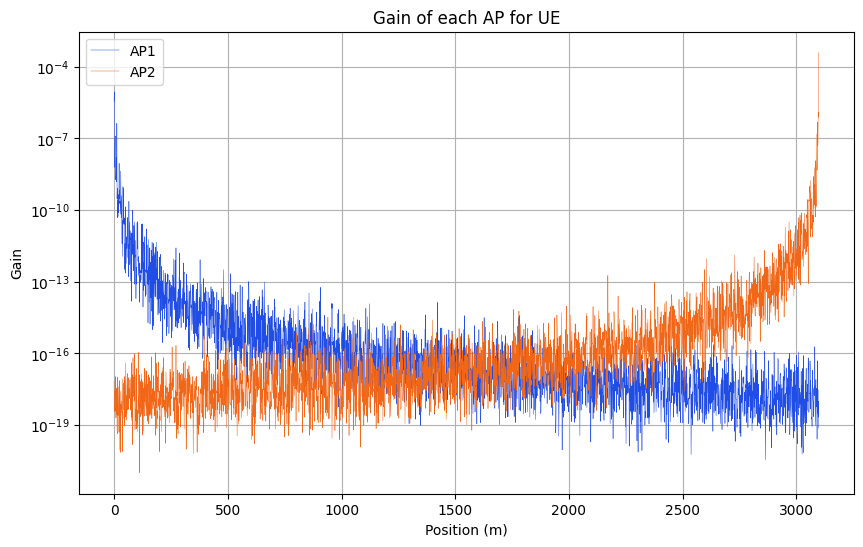

In [ ]:
# @title
import numpy as np
import matplotlib.pyplot as plt

class AP:
    def __init__(self, x: float, y: float):
        self.x = x
        self.y = y
        self.id = id
        self.channel = None
        self.ues = []

    def __str__(self):
        return f'AP[{self.id}]({self.x}, {self.y})'

class UE:
    id_counter = 0
    def __init__(self, x: float, y: float):
        self.id = UE.id_counter
        UE.id_counter += 1
        self.x = x
        self.y = y
        self.ap = None
        self.channel = 0
        self.dist = 0
        self.gain = 0
        self.ca = False
        self.sinr = 0

    def __str__(self):
        return f'UE({self.x}, {self.y})'

    def __eq__(self, other):
        if isinstance(other, UE):
            return self.id == other.id
        return False


def attach_AP_UE(ue: UE, aps: list) -> float:
    ap_coords = np.array([[ap.x, ap.y] for ap in aps])

    # Cálculo vetorizado do ganho
    x = np.random.lognormal(0, 2, len(aps))
    distances = np.linalg.norm(ap_coords - np.array([ue.x, ue.y]), axis=1)
    gains = x * 1e-4 / (distances ** 4)

    return gains

def simular_experimento():
    ap1 = AP(0, 0)
    ap2 = AP(3100, 0)
    ue1 = UE(1, 0)
    gains = np.zeros((2, 3099))

    for n in range(3099):
        gains1, gains2 = attach_AP_UE(ue1, [ap1, ap2])
        ue1.x += 1
        gains[0, n] = gains1
        gains[1, n] = gains2

    return gains

def plot_gain(gains: np.ndarray):
    plt.figure(figsize=(10, 6))
    plt.semilogy(range(len(gains[0])), gains[0], linewidth = 0.35, color='#1F4DE6', label='AP1')
    plt.semilogy(range(len(gains[1])), gains[1], linewidth = 0.35, color="#F16717", label='AP2')
    plt.xlabel('Position (m)')
    plt.ylabel('Gain')
    plt.title('Gain of each AP for UE')
    plt.grid()
    plt.legend()
    plt.show()

if __name__ == "__main__":

    gains = simular_experimento()
    plot_gain(gains)

### Exercício 11

Outages soft handover: 9
Outages hard handover: 29 



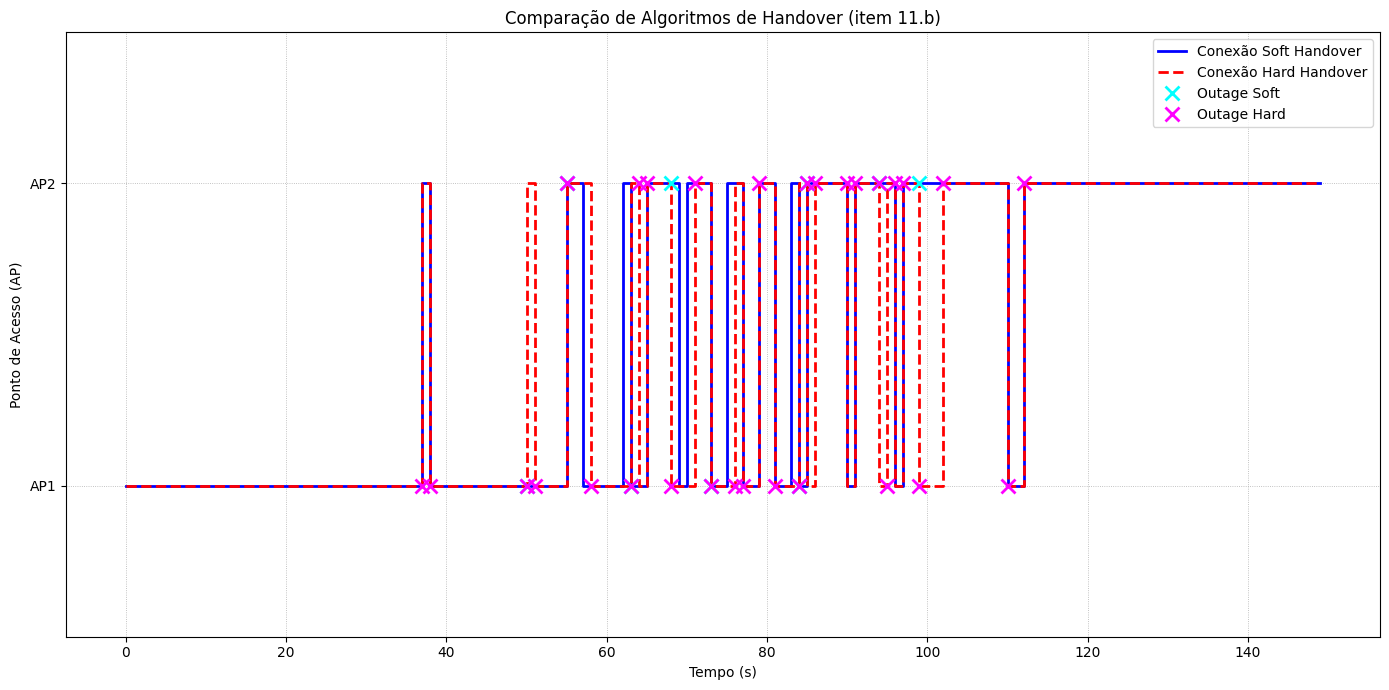

In [ ]:
# @title
import numpy as np
import matplotlib.pyplot as plt

# --- Parâmetros da Simulação (baseado no Exercício 11) ---
DISTANCIA_APs = 3100.0  # Distância total entre APs em metros
VELOCIDADE_UE = 20.0     # Velocidade do UE em m/s
T_S = 1.0                # Período de amostragem em segundos (Ts)
P_MIN = 1e-17            # Limiar de potência para outage em Watts
TRAJETO_INICIO = 50.0    # UE começa a 50m do AP1
TRAJETO_FIM = DISTANCIA_APs - 50.0 # UE termina a 50m do AP2

# --- Parâmetros do Canal ---
K_CANAL = 1e-4           # Constante de propagação k
N_CANAL = 4              # Expoente de perda de percurso n
SIGMA_X = 2              # Desvio padrão do sombreamento (shadowing)

class AP:
    def __init__(self, x: float, y: float, id_ap: int):
        self.x = x
        self.y = y
        self.id = id_ap

    def __str__(self):
        return f'AP[{self.id}]({self.x}, {self.y})'

class UE:
    def __init__(self, x: float, y: float):
        self.x = x
        self.y = y

    def __str__(self):
        return f'UE({self.x}, {self.y})'

def calcular_ganho_canal(ue: UE, aps: list) -> np.ndarray:
    """
    Calcula o ganho de canal do UE para uma lista de APs, incluindo o sombreamento.
    Retorna um array com os ganhos.
    """
    ap_coords = np.array([[ap.x, ap.y] for ap in aps])
    ue_coords = np.array([ue.x, ue.y])

    # Sorteia uma variável lognormal para o sombreamento para cada AP
    x_shadowing = np.random.lognormal(0, SIGMA_X, len(aps))

    # Calcula as distâncias do UE a todos os APs
    distances = np.linalg.norm(ap_coords - ue_coords, axis=1)

    # Calcula o ganho usando a fórmula do documento
    gains = x_shadowing * K_CANAL / (distances ** N_CANAL)

    return gains

def simular_experimento():
    """
    Executa uma única simulação da travessia do UE, aplicando as regras de
    handover Soft e Hard a cada passo de tempo.
    """
    ap1 = AP(0, 0, id_ap=1)
    ap2 = AP(DISTANCIA_APs, 0, id_ap=2)
    aps = [ap1, ap2]

    # O UE começa sua jornada na posição inicial
    ue = UE(TRAJETO_INICIO, 0)

    # Calcula o número total de passos na simulação
    distancia_total_percurso = TRAJETO_FIM - TRAJETO_INICIO
    tempo_total = distancia_total_percurso / VELOCIDADE_UE
    num_passos = int(np.ceil(tempo_total / T_S))

    # Vetores para armazenar os resultados a cada passo
    tempos = np.arange(num_passos) * T_S
    posicoes = np.zeros(num_passos)

    conexoes_soft = np.zeros(num_passos, dtype=int)
    outages_soft = np.zeros(num_passos, dtype=bool)

    conexoes_hard = np.zeros(num_passos, dtype=int)
    outages_hard = np.zeros(num_passos, dtype=bool)

    # Condição inicial: UE começa conectado ao AP1 para ambos os algoritmos
    conexoes_hard[0] = ap1.id

    for t in range(num_passos):
        # Atualiza a posição do UE
        ue.x = TRAJETO_INICIO + t * VELOCIDADE_UE * T_S
        posicoes[t] = ue.x

        # Calcula o ganho para os dois APs na posição atual
        ganho_ap1, ganho_ap2 = calcular_ganho_canal(ue, aps)

        # --- Lógica do Soft Handover ---
        # Conecta-se sempre ao AP com maior ganho (potência)
        if ganho_ap1 > ganho_ap2:
            conexoes_soft[t] = ap1.id
            ganho_conectado = ganho_ap1
        else:
            conexoes_soft[t] = ap2.id
            ganho_conectado = ganho_ap2

        # Verifica se há outage no Soft Handover
        if ganho_conectado < P_MIN:
            outages_soft[t] = True

        # --- Lógica do Hard Handover ---
        # A decisão depende da conexão no passo anterior (se t > 0)
        ap_conectado_anterior = conexoes_hard[t-1] if t > 0 else conexoes_hard[0]

        ganho_do_ap_conectado = ganho_ap1 if ap_conectado_anterior == ap1.id else ganho_ap2

        # Verifica se há outage no Hard Handover
        if ganho_do_ap_conectado < P_MIN:
            outages_hard[t] = True
            # Se houve outage, a conexão no próximo passo mudará para o outro AP
            proximo_ap = ap2.id if ap_conectado_anterior == ap1.id else ap1.id
        else:
            # Se não houve outage, a conexão é mantida
            proximo_ap = ap_conectado_anterior

        # Atualiza a conexão para o passo atual (exceto o último)
        if t < num_passos -1:
            conexoes_hard[t] = proximo_ap
        else: # No último passo, a conexão é a mesma do anterior
             conexoes_hard[t] = ap_conectado_anterior


    return {
        "tempos": tempos,
        "posicoes": posicoes,
        "conexoes_soft": conexoes_soft,
        "outages_soft": outages_soft,
        "conexoes_hard": conexoes_hard,
        "outages_hard": outages_hard,
    }

def plot_handover_comparison(resultados: dict):
    """
    Plota o gráfico comparativo dos algoritmos de handover, conforme item b.
    """
    tempos = resultados["tempos"]

    fig, ax = plt.subplots(figsize=(14, 7))

    # --- Plotar linhas de conexão ---
    # Usamos 'step' para mostrar claramente as transições discretas
    ax.step(tempos, resultados["conexoes_soft"], where='post',
            label='Conexão Soft Handover', color='blue', linewidth=2)
    ax.step(tempos, resultados["conexoes_hard"], where='post',
            label='Conexão Hard Handover', color='red', linestyle='--', linewidth=2)

    # --- Marcar os outages ---
    # Encontra os pontos onde houve outage
    t_outage_soft = tempos[resultados["outages_soft"]]
    conn_outage_soft = resultados["conexoes_soft"][resultados["outages_soft"]]

    t_outage_hard = tempos[resultados["outages_hard"]]
    # A conexão durante o outage do hard handover é a do AP que falhou
    conn_outage_hard = resultados["conexoes_hard"][np.roll(resultados["outages_hard"], 1)]
    conn_outage_hard[0] = resultados["conexoes_hard"][0]


    if t_outage_soft.any():
        ax.plot(t_outage_soft, conn_outage_soft, 'x', color='cyan',
                markersize=10, markeredgewidth=2, label='Outage Soft')
    if t_outage_hard.any():
        ax.plot(t_outage_hard, conn_outage_hard, 'x', color='magenta',
                markersize=10, markeredgewidth=2, label='Outage Hard')

    # --- Configurações do Gráfico ---
    ax.set_xlabel('Tempo (s)')
    ax.set_ylabel('Ponto de Acesso (AP)')
    ax.set_title('Comparação de Algoritmos de Handover (item 11.b)')
    ax.set_yticks([1, 2])
    ax.set_yticklabels(['AP1', 'AP2'])
    ax.set_ylim(0.5, 2.5)
    ax.grid(True, which='both', linestyle=':', linewidth=0.6)
    ax.legend()

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    np.random.seed(42)

    # Executa a simulação
    resultados_simulacao = simular_experimento()
    # print(resultados_simulacao)
    print(f'Outages soft handover: {np.sum([1 for _ in resultados_simulacao["outages_soft"] if _ ==True])}')
    print(f'Outages hard handover: {np.sum([1 for _ in resultados_simulacao["outages_hard"] if _ ==True])} \n')

    # Plota o gráfico comparativo
    plot_handover_comparison(resultados_simulacao)

Comparando os dois algoritmos de handover, vemos que o *Soft Handover* apresenta um melhor desempenho. Isso ocorre por conta da constante troca entre os APs, selecionando a melhor opção para cada UE. Isso adiciona uma complexidade extra ao sistema, que deve sempre monitorar a situação dos AP para determinado UE. Essa escolha resulta em menos eventos de *outage*. Por outro lado, no algoritmo de *Hard Handover*, sempre que há uma troca a interrupção no serviço já aconteceu. Logo, oferece um serviço abaixo para o usuário.